In [52]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import os
import glob
import random

import cv2
import pydot
import graphviz

import tensorflow.keras.backend as K
from skimage import exposure

In [53]:
# Define a class that tracks the file version number
class VersionCounter:
    def __init__(self):
        self.value = 1
        
    def counting(self):
        self.value += 1
        
    def reset(self):
        self.value = 1
    
    def set_manually(self, set_value):
        self.value = set_value
        
VERSION = VersionCounter()

In [54]:
VERSION.set_manually(24)
VERSION.value
# Version 8: Test with transformation and rescale
# Version 9: Test with transformaiton, rescale and grayscale
# Version 10: Test with the new loss function : iou
# Version 11: Test with the same iou loss function but with 40 epochs
# Version 12: Test with more robust iou loss function with 40 epochs (deal with non overlapping iou)
# Version 13: Test with the distance iou loss function: 20 epochs
# Version 14: with batch size 16
# Version 15: bbox loss weightage 2, learning rate 0.00002
# Version 16: starts with "main_full.ipy" file, with completed dataset
# Version 22: add webcam image as background
# Version 23: Deepen the fc layer for iou metrics neuron
# Version 24: add more webcam image, add image enhance to increase variation

24

# Modify the bottom section only to keep track of the version number

In [55]:
# Define the specific path
# For background images
BG_IMAGE_TYPE = ['Cluttered', 'Patterned', 'Random Places', 'Colour', 'Fashion', 'Indoor', 'People', 'Pure Colour', 'Kids', 'Female', 'Male', 'Webcam']
BG_IMAGE_PATH = "Image/CollectedImage/Background_Image_Blurred_Resized_350/*/*.jp*g"

# For hand images
HAND_IMAGE_TYPE = {0:'alphabet_a', 1:'alphabet_b', 2:'alphabet_c', 3:'alphabet_d', 4:'alphabet_e', 5:'alphabet_f', 6:'alphabet_g', 7:'alphabet_h', 8:'alphabet_i', 
                   9:'alphabet_j', 10:'alphabet_k', 11:'alphabet_l', 12:'alphabet_m', 13:'alphabet_n', 14:'alphabet_o', 15:'alphabet_p', 16:'alphabet_q', 17:'alphabet_r', 
                   18:'alphabet_s', 19:'alphabet_t', 20:'alphabet_u', 21:'alphabet_v', 22:'alphabet_w', 23:'alphabet_x', 24:'alphabet_y', 25:'alphabet_z'}

# Directory for storing the model and its weight
version_num = VERSION.value
MODEL_PATH = "Model/v{}".format(version_num)
print("Version: {}".format(version_num))

Version: 24


# 1) Load the images

In [56]:
# Set up the directory for saving the generated figures later on
ARRAY_PATH = "{}/Array".format(MODEL_PATH)

if not os.path.exists(path=ARRAY_PATH):
    os.makedirs(ARRAY_PATH)
    print("The following directory:'{}'has been made.".format(ARRAY_PATH))
else:
    pass

In [57]:
# Load all the backgorund images of all type within the specific directory
bg_image_list = glob.glob(BG_IMAGE_PATH)
bg_image_list

['Image/CollectedImage/Background_Image_Blurred_Resized_350\\Background Office\\background office_00.jpg',
 'Image/CollectedImage/Background_Image_Blurred_Resized_350\\Background Office\\background office_01.jpg',
 'Image/CollectedImage/Background_Image_Blurred_Resized_350\\Background Office\\background office_02.jpg',
 'Image/CollectedImage/Background_Image_Blurred_Resized_350\\Background Office\\background office_03.jpg',
 'Image/CollectedImage/Background_Image_Blurred_Resized_350\\Background Office\\background office_04.jpg',
 'Image/CollectedImage/Background_Image_Blurred_Resized_350\\Background Office\\background office_05.jpg',
 'Image/CollectedImage/Background_Image_Blurred_Resized_350\\Background Office\\background office_06.jpg',
 'Image/CollectedImage/Background_Image_Blurred_Resized_350\\Background Office\\background office_07.jpg',
 'Image/CollectedImage/Background_Image_Blurred_Resized_350\\Background Office\\background office_08.jpg',
 'Image/CollectedImage/Background_Ima

In [58]:
# Total number of background images
len(bg_image_list)

3422

In [59]:
ARRAY_PATH

'Model/v24/Array'

In [60]:
# Shuffle the background image path and split the background image into train set and validation set later
#np.random.shuffle(bg_image_list)
#np.save(file=os.path.join(ARRAY_PATH, "Shuffled_Background_Image_Path"), arr=bg_image_list)
bg_image_list = np.load('Model/v{}/Array/Shuffled_Background_Image_Path.npy'.format(version_num))
bg_image_list

array(['Image/CollectedImage/Background_Image_Blurred_Resized_350\\People\\people_82.jpg',
       'Image/CollectedImage/Background_Image_Blurred_Resized_350\\People\\people_484.jpg',
       'Image/CollectedImage/Background_Image_Blurred_Resized_350\\Webcam\\webcam_48.jpg',
       ...,
       'Image/CollectedImage/Background_Image_Blurred_Resized_350\\Fashion\\fashion_370.jpg',
       'Image/CollectedImage/Background_Image_Blurred_Resized_350\\Male\\male_164.jpg',
       'Image/CollectedImage/Background_Image_Blurred_Resized_350\\Male\\male_37.jpg'],
      dtype='<U101')

In [61]:
train_bg_list = bg_image_list[0 : int(0.95*len(bg_image_list))]
len(train_bg_list)

3250

In [62]:
validation_bg_list = bg_image_list[int(0.95*len(bg_image_list)):]
len(validation_bg_list)

172

# 2) Define the ImageGenerator

In [63]:
def displace_rgb(frame):
    frame[frame==0] = 1 # Replace all the 0 values with 1, avoid returning max value after displacment
    frame_int16 = frame.astype(dtype=np.int16) # Convert to 16 bit integer datatype to allow values above 255, specifically 2^16
    
    # Slice each channel and sum them up
    r_channel = frame_int16[:,:,0]
    g_channel = frame_int16[:,:,1]
    b_channel = frame_int16[:,:,2]
    sum_channel = r_channel + g_channel + b_channel
    
    # Displace the original RGB vectors to a new RGB vectors
    # While keeping the Hue and Saturation constant, only changing the Value
    frame_int16[:,:,0] = frame_int16[:,:,0] * (255 / sum_channel)
    frame_int16[:,:,1] = frame_int16[:,:,1] * (255 / sum_channel)
    frame_int16[:,:,2] = frame_int16[:,:,2] * (255 / sum_channel)
    
    # Convert back to uint8 (0-255)
    transformed_int8 = frame_int16.astype(dtype=np.uint8)
    
    return transformed_int8

In [64]:
def rescale(image, q_percentile):
    q1, q2 = np.percentile(image, q_percentile)
    image = exposure.rescale_intensity(image, in_range=(q1,q2), out_range='uint8')
    return image

In [65]:
def conv_grayscale(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

In [66]:
def transformation(image, q_percentile, grayscale_bool=False):
    # This is a pixel-wise transformation, independent of the global/neighbouring pixel value
    # Convert the RGB into RGB-equivalent of HSV space where V becomes constant (independent of V)
    # The output usually centered around pixel value 85
    displaced_rgb = displace_rgb(frame=image)
    # Rescale the pixel value to spread them out between 0 and 255
    displaced_rgb_rescaled = rescale(image=displaced_rgb, q_percentile=q_percentile)
    if grayscale_bool == True:
        displaced_rgb_rescaled_gray = conv_grayscale(image=displaced_rgb_rescaled)
    return displaced_rgb_rescaled if grayscale_bool==False else displaced_rgb_rescaled_gray

In [67]:
# Ref: https://stackoverflow.com/questions/32609098/how-to-fast-change-image-brightness-with-python-opencv
def change_brightness(img, value=30):
    hsv = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    # Set a random condition to determine whether to increase or decrease the brightness
    in_bright = (np.random.random() < 0.5)
    if in_bright == True:
        limit = 255 - value
        v[v > limit] = 255
        v[v <= limit] += value
    else:
        limit = 0 + value
        v[v < limit] = 0
        v[v >= limit] -= value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
    return img

In [68]:
# def image_generator(background_img_list, batch, batch_size, image_row, image_col, transform_bool=False, grayscale_bool=False, q_percentile=(0,100)):
#     while True:
#         # For each batch of a single epoch, generate batch size number of images of specific resolution (image_row, image_col)
#         for _ in range(batch):
#             # Define a black image that will be replaced by a random hand fingerspelling image pasting on a random background
#             X = np.zeros(shape=(batch_size, image_row, image_col, 3))
            
#             if transform_bool == True:
#                 if grayscale_bool == True:
#                     X_gray = np.zeros(shape=(batch_size, image_row, image_col, 1))
                    
#             # Define the target array that will be replaced the correct value later
#             # There is 26 (num of category) + 2 (1 coordinate) + 2 (bounding box resolution) + 1 (presence of object) = 31 outputs
#             Y = np.zeros(shape=(batch_size, 31))
            
#             # Starts the random image configuration from here
#             for i in range(batch_size):
#                 # Pick a random background image path and load it
#                 bg_image_choice = np.random.choice(background_img_list)
#                 bg_image = cv2.imread(bg_image_choice)
#                 bg_image = bg_image
#                 bg_image_row = bg_image.shape[0] # Background image height
#                 bg_image_col = bg_image.shape[1] # Background image width
#                 # Crop the background image into our desired dimension
#                 # Top left coordinate in the background image
#                 bg_image_row0 = np.random.randint(low=0, high=(bg_image_row - image_row))
#                 bg_image_col0 = np.random.randint(low=0, high=(bg_image_col - image_col))
#                 # Bottom right coordinate in the background image
#                 bg_image_row1 = bg_image_row0 + image_row
#                 bg_image_col1 = bg_image_col0 + image_col
#                 # Slice the zero array and replace it with the background image array (for a single batch)
#                 X[i,:,:,:] = bg_image[bg_image_row0:bg_image_row1, bg_image_col0:bg_image_col1, :]
                
#                 # Determine whether to flip the background image
#                 flip = (np.random.random() < 0.50)
#                 if flip:
#                     X[i,:,:,:] = np.fliplr(X[i,:,:,:])
                
#                 # Determine whether the hand appears or not
#                 appear = (np.random.random() < 0.80)
#                 if appear:
#                     # Pick a random fingerspelling alphabet and then pick a random image from that category
#                     # A number between 0 and 7 (8 types of alphabets)
#                     hand_type_index = np.random.choice(len(HAND_IMAGE_TYPE))
#                     # Choose a random alphabet based on the index above
#                     hand_type_choice = HAND_IMAGE_TYPE[hand_type_index]
#                     HAND_IMAGE_PATH = glob.glob("Image/CollectedImage/Hand_Image_Cropped_Further/{}/*.*g".format(hand_type_choice))
#                     # Choose a random image of the specific chosen alphabet
#                     hand_image_choice = np.random.choice(HAND_IMAGE_PATH)
#                     hand_image = cv2.imread(hand_image_choice)
                    
#                     # Resize the image depending on the resize factor
#                     resize_factor = np.random.uniform(low=0.75, high=1.0) # Resize factor between 0.35 and 0.65
#                     hand_image = cv2.resize(src=hand_image, dsize=(int(hand_image.shape[1]*resize_factor), int(hand_image.shape[0]*resize_factor)))
#                     hand_image_row = hand_image.shape[0] # Resized hand image height
#                     hand_image_col = hand_image.shape[1] # Resized hand image width
#                     # Top left coordinate in the output/cropped background image
#                     hand_image_row0 = np.random.randint(low=0, high=(image_row - hand_image_row))
#                     hand_image_col0 = np.random.randint(low=0, high=(image_col - hand_image_col))
#                     # Bottom right coordinate in the output/cropped background image
#                     hand_image_row1 = hand_image_row0 + hand_image_row
#                     hand_image_col1 = hand_image_col0 + hand_image_col
                    
#                     # Create a mask from the hand image and paste the hand image into the background
#                     # Crop a mask from the background image where the hands will be
#                     bg_mask = X[i,hand_image_row0:hand_image_row1, hand_image_col0:hand_image_col1, :]
#                      # A binary image where the hands pixel will be "False", whereas the black background will be "True"
#                     hand_mask = (hand_image == 0) # Shape of (hand_image_row, hand_image_col, 3)
#                     # An image where the hand pixel is black, whereas the background pixel remains
#                     # NOTE: black has pixel value 0, so any pixel value * black = black
#                     mask = bg_mask * hand_mask
#                     # An image where the hand pixels are pasted into the background image
#                     # NOTE: black has pixel value of 0, so any pixel value + black = that pixel value
#                     mask += hand_image
#                     # Paste the mask back into the background image
#                     X[i, hand_image_row0:hand_image_row1, hand_image_col0:hand_image_col1, :] = mask
                    
#                     if transform_bool == True:
#                         if grayscale_bool == True:
#                             X_gray[i, :, :, :] = np.expand_dims(transformation(image=X[i, :, :, :], q_percentile=q_percentile, grayscale_bool=grayscale_bool), 2) / 255.0
#                         else:
#                             X[i, :, :, :] = transformation(image=X[i, :, :, :], q_percentile=q_percentile, grayscale_bool=grayscale_bool) / 255.0
                            
#                     else:
#                         X[i, :, :, :] = X[i, :, :, :] / 255.0
                    
                
#                     # Define the target
#                     # 0: Presence of object, 1 denotes being present while 0 being absent
#                     Y[i, 0] = 1.0
#                     # 1 - 26: Classification target
#                     Y[i, 1 + hand_type_index] = 1.0
#                     # 9 - 12: Upper left coordinates, height, width of the hand image
#                     # NOTE: height and width of the image are used instead of the X, Y coordinate because sigmoid activation function only ensures
#                     # that the output is between 0 and 1, centered at 0.5 but doesn't ensure that the output is greater than the upper left corner coordinates
#                     Y[i, 26 + 1] = hand_image_row0 / image_row # Y coordinate of the hand upper left corner of the segmented hand image
#                     Y[i, 26 + 2] = hand_image_col0 / image_col # X coordinate of the hand upper left corner of the segmented hand image
#                     Y[i, 26 + 3] = hand_image_row / image_row # Height of the segmented hand image
#                     Y[i, 26 + 4] = hand_image_col / image_col # Width of the segmented hand image
                   
#                 else:
#                     if transform_bool == True:
#                         if grayscale_bool == True:
#                             X_gray[i,:,:,:] = np.expand_dims(transformation(image=X[i, :, :, :], q_percentile=q_percentile, grayscale_bool=grayscale_bool),2) / 255.0
#                         else:
#                             X[i,:,:,:] = transformation(image=X[i, :, :, :], q_percentile=q_percentile, grayscale_bool=grayscale_bool) / 255.0
#                     else:
#                         X[i, :, :, :] = X[i, :, :, :] / 255.0
                            
#             yield (X, Y) if grayscale_bool == False else (X_gray, Y)

In [69]:
def image_generator(background_img_list, batch_size, image_row, image_col, transform_bool=False, grayscale_bool=False, q_percentile=(0,100)):
    while True:
        # Define a black image that will be replaced by a random hand fingerspelling image pasting on a random background
        X = np.zeros(shape=(batch_size, image_row, image_col, 3))
            
        if transform_bool == True:
            if grayscale_bool == True:
                X_gray = np.zeros(shape=(batch_size, image_row, image_col, 1))
                    
        # Define the target array that will be replaced by the correct value later
        # There is 26 (num of category) + 2 (1 coordinate) + 2 (bounding box resolution) + 1 (presence of object) = 31 outputs
        Y = np.zeros(shape=(batch_size, 31))
            
        # Starts the random image configuration from here
        for i in range(batch_size):
            # Pick a random background image path and load it
            bg_image_choice = np.random.choice(background_img_list)
            bg_image = cv2.imread(bg_image_choice)
            bg_image_row = bg_image.shape[0] # Background image height
            bg_image_col = bg_image.shape[1] # Background image width
            # Crop the background image into our desired dimension
            # Top left coordinate in the background image
            bg_image_row0 = np.random.randint(low=0, high=(bg_image_row - image_row))
            bg_image_col0 = np.random.randint(low=0, high=(bg_image_col - image_col))
            # Bottom right coordinate in the background image
            bg_image_row1 = bg_image_row0 + image_row
            bg_image_col1 = bg_image_col0 + image_col
            # Slice the zero array and replace it with the background image array (for a single batch)
            X[i,:,:,:] = bg_image[bg_image_row0:bg_image_row1, bg_image_col0:bg_image_col1, :]
                
            # Determine whether to flip the background image
            flip = (np.random.random() < 0.50)
            if flip:
                X[i,:,:,:] = np.fliplr(X[i,:,:,:])
            
            # Determine whether the hand appears or not
            appear = (np.random.random() < 0.85)
            if appear:
                # Pick a random fingerspelling alphabet and then pick a random image from that category
                # A number between 0 and 7 (8 types of alphabets)
                hand_type_index = np.random.choice(len(HAND_IMAGE_TYPE))
                # Choose a random alphabet based on the index above
                hand_type_choice = HAND_IMAGE_TYPE[hand_type_index]
                HAND_IMAGE_PATH = glob.glob("Image/CollectedImage/Hand_Image_Cropped_Further/{}/*.*g".format(hand_type_choice))
                # Choose a random image of the specific chosen alphabet
                hand_image_choice = np.random.choice(HAND_IMAGE_PATH)
                hand_image = cv2.imread(hand_image_choice)
                    
                # Resize the image depending on the resize factor
                resize_factor = np.random.uniform(low=0.45, high=0.65) # Resize factor between 0.35 and 0.65, 0.7 and 1.0 for img_row=480
                hand_image = cv2.resize(src=hand_image, dsize=(int(hand_image.shape[1]*resize_factor), int(hand_image.shape[0]*resize_factor)))
                hand_image_row = hand_image.shape[0] # Resized hand image height
                hand_image_col = hand_image.shape[1] # Resized hand image width
                # Top left coordinate in the output/cropped background image
                hand_image_row0 = np.random.randint(low=0, high=(image_row - hand_image_row))
                hand_image_col0 = np.random.randint(low=0, high=(image_col - hand_image_col))
                # Bottom right coordinate in the output/cropped background image
                hand_image_row1 = hand_image_row0 + hand_image_row
                hand_image_col1 = hand_image_col0 + hand_image_col
                    
                # Create a mask from the hand image and paste the hand image into the background
                # Crop a mask from the background image where the hands will be
                bg_mask = X[i,hand_image_row0:hand_image_row1, hand_image_col0:hand_image_col1, :]
                # A binary image where the hands pixel will be "False", whereas the black background will be "True"
                hand_mask = (hand_image == 0) # Shape of (hand_image_row, hand_image_col, 3)
                # An image where the hand pixel is black, whereas the background pixel remains
                # NOTE: black has pixel value 0, so any pixel value * black = black
                # NOTE: "True" is equivalent to 1, "False" is equivalent to 0
                mask = bg_mask * hand_mask
                # An image where the hand pixels are pasted into the background image
                # NOTE: black has pixel value of 0, so any pixel value + black = that pixel value
                mask += hand_image
                # Paste the mask back into the background image
                X[i, hand_image_row0:hand_image_row1, hand_image_col0:hand_image_col1, :] = mask
                
                # Change the brightness of image
                modify_brightness = (np.random.random() < 0.8)
                if modify_brightness:
                    X[i,:,:,:] = change_brightness(img=X[i,:,:,:], value=int(np.random.uniform(10, 70)))
                    
                if transform_bool == True:
                    if grayscale_bool == True:
                        X_gray[i, :, :, :] = np.expand_dims(transformation(image=X[i, :, :, :], q_percentile=q_percentile, grayscale_bool=grayscale_bool), 2) / 255.0
                    else:
                        X[i, :, :, :] = transformation(image=X[i, :, :, :], q_percentile=q_percentile, grayscale_bool=grayscale_bool) / 255.0
                            
                else:
                    X[i, :, :, :] = X[i, :, :, :] / 255.0
                    
                    
                
                # Define the target
                # 0: Presence of object, 1 denotes being present while 0 being absent
                Y[i, 0] = 1.0
                # 1 - 26: Classification target
                Y[i, 1 + hand_type_index] = 1.0
                # 9 - 12: Upper left coordinates, height, width of the hand image
                # NOTE: height and width of the image are used instead of the X, Y coordinate because sigmoid activation function only ensures
                # that the output is between 0 and 1, centered at 0.5 but doesn't ensure that the output is greater than the upper left corner coordinates
                Y[i, 26 + 1] = hand_image_row0 / image_row # Y coordinate of the hand upper left corner of the segmented hand image
                Y[i, 26 + 2] = hand_image_col0 / image_col # X coordinate of the hand upper left corner of the segmented hand image
                Y[i, 26 + 3] = hand_image_row / image_row # Height of the segmented hand image
                Y[i, 26 + 4] = hand_image_col / image_col # Width of the segmented hand image
                   
            else:
                # Change the brightness of image
                modify_brightness = (np.random.random() < 0.8)
                if modify_brightness:
                    X[i,:,:,:] = change_brightness(img=X[i,:,:,:], value=int(np.random.uniform(10, 70)))
                
                
                if transform_bool == True:
                    if grayscale_bool == True:
                        X_gray[i,:,:,:] = np.expand_dims(transformation(image=X[i, :, :, :], q_percentile=q_percentile, grayscale_bool=grayscale_bool),2) / 255.0
                    else:
                        X[i,:,:,:] = transformation(image=X[i, :, :, :], q_percentile=q_percentile, grayscale_bool=grayscale_bool) / 255.0
                else:
                    X[i, :, :, :] = X[i, :, :, :] / 255.0
                            
        yield (X, Y) if grayscale_bool == False else (X_gray, Y)

In [70]:
# Inspect the image generator output X, Y
for x, y in image_generator(train_bg_list, 50, 300, 300, False, False, (0,100) ):
    xx = x
    yy = y
    break

choice = 0

Object Presence: 1.0
Category: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Coordinate: [0.21666667 0.07333333 0.22       0.58666667]


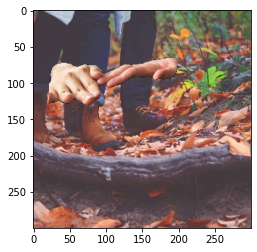

In [71]:
plt.imshow(cv2.cvtColor(xx[choice].astype(np.float32), cv2.COLOR_BGR2RGB))
print("Object Presence: {}".format(yy[choice][0]))
print("Category: {}".format(yy[choice][1:27]))
print("Coordinate: {}".format(yy[choice][27:31]))
if choice < 50:
    choice += 1
else:
    pass

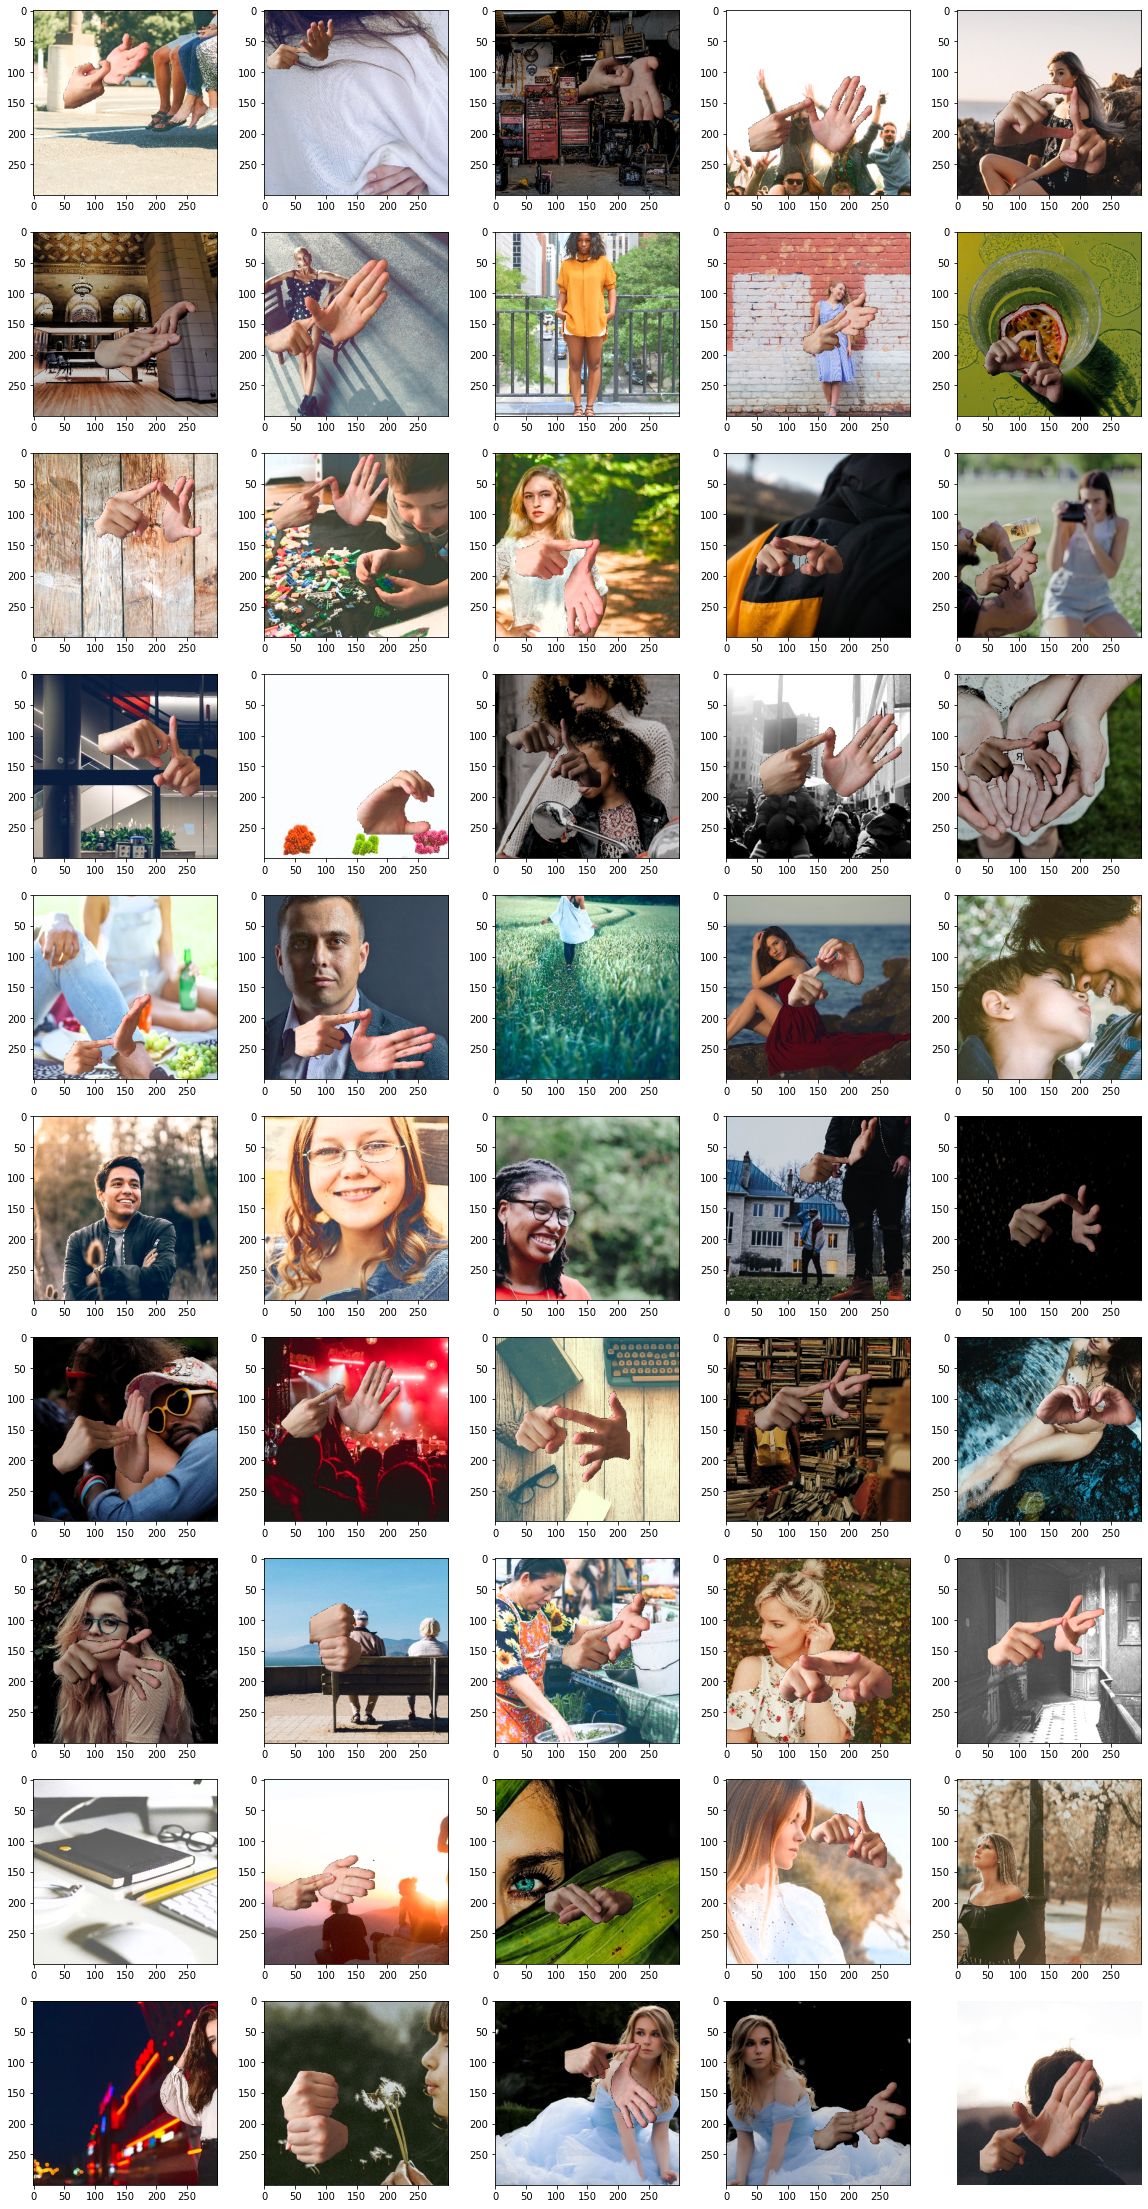

In [51]:
# To show multiple generated images at once
choice = 0
img_row = 10
img_col = 5


plt.figure(figsize=(20,40))
#plt.subplots(nrows=10, ncols=5)

for row in range(img_row):
    for col in range(img_col):
        plt.subplot(img_row, img_col, choice+1)
        plt.imshow(cv2.cvtColor(xx[choice].astype(np.float32), cv2.COLOR_BGR2RGB))
        choice += 1

plt.grid = False
plt.axis('off')
plt.savefig("Model/v24/Figure/Image_sample.jpg")
plt.show()

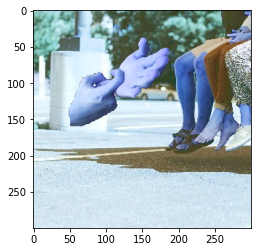

In [34]:
plt.imshow(xx[0])

# 3) Define custom loss function, metrics and the model

In [72]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Concatenate, Flatten
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [73]:
# NOTE: metrics are computed for every batch of any epoch
def calculate_iou(y_true, y_pred):
    iou_result = []
    
    # Loop through every component of a batch
    for i in range(y_true.shape[0]):
        # Set the dtype (it's important to avoid alot of debugging later on)
        y_true = y_true.astype(np.float64)
        y_pred = y_pred.astype(np.float64)
        
        # For ground truth bounding box
        # upper left corner coordinate
        x1_gtruth = y_true[i,26+2]
        y1_gtruth = y_true[i,26+1]
        # lower right corner coordinate
        x2_gtruth = x1_gtruth + y_true[i,26+4]
        y2_gtruth = y1_gtruth + y_true[i,26+3]
        # Area of the ground truth bounding box (This will be used to calculate the Union Area later)
        area_gtruth = (y_true[i,26+4]) * (y_true[i,26+3])
        
        # For predicted bounding box
        # upper left corner coordinate
        x1_pred = y_pred[i,26+2]
        y1_pred = y_pred[i,26+1]
        # Lower right corner coordinate
        x2_pred = x1_pred + y_pred[i,26+4]
        y2_pred = y1_pred + y_pred[i,26+3]
        # Area of the predicted bounding box (Again, will be used to calculate the Union Area later)
        area_pred = (y_pred[i,26+4]) * (y_pred[i,26+3])
        
        # Calculate the upper left coordinates of the intersected area
        x1_intersect = np.max([x1_gtruth, x1_pred])
        y1_intersect = np.max([y1_gtruth, y1_pred])
        # Calculate the lower right coordinate of the intersected area
        x2_intersect = np.min([x2_gtruth, x2_pred])
        y2_intersect = np.min([y2_gtruth, y2_pred])
        
        # Calculate the area of intersection
        area_intersect = (x2_intersect - x1_intersect) * (y2_intersect - y1_intersect)
        # Calculate the union area
        area_union = (area_gtruth + area_pred -  area_intersect)
        
        # Calculate the IoU
        iou = area_intersect / area_union
        
        # Append to the list of IoU to calculate the average IoU for a batch
        iou_result.append(iou)
        
    iou_mean = np.mean(iou_result)
    
    return iou_result


In [74]:
def presence_accuracy(y_true, y_pred):
    # input shape, output shape are the same: (batch_size, d0, d1, d2)
    # this is evaluated batch by batch, output: (batch)
    # Accuracy corresponds to the object presence
    # float32 is used to avoid memory overload issues
    y_true = K.cast(y_true, "float32")
    y_pred = K.cast(y_pred, "float32")
    return tf.keras.metrics.binary_accuracy(y_true[:,0], y_pred[:,0], threshold=0.5)

In [75]:
def classification_accuracy(y_true, y_pred):
    # A metrics function that calculates classification accuracy
    # The function is built from categorical_accuracy with a slight tweak
    # This is because the model still predict the class of the object even when
    # the object is not present, this introduces error to the standard categorical_accuracy calculation
    # So, the components of a batch that have object being present are isolated in which the accuracy
    # is calculated separately, independent of components that have object being absent
    
    # Convert the object dtype to dtype of smaller bit to avoid memory overload
    y_true = K.cast(x=y_true, dtype="float32")
    y_pred = K.cast(x=y_pred, dtype="float32")
    
    # Select only the components with the object being present
    y_true_present = y_true[y_true[:,0]==1] # One-hot encoded of the class
    y_pred_present = y_pred[y_true[:,0]==1] # One-hot encoded of the predicted class
    
    # Calculate the accuracy of the label
    # Output shape: (batch_size, ) e.g. array([1., 0., 1., 1., 0 .... ])
    acc_array = tf.keras.metrics.categorical_accuracy(y_true=y_true_present[:, 1:27], y_pred=y_pred_present[:, 1:27])
    
    # Calculate the (number of correctly predicted target / total number of component which have object being present)
    # y_true_present, in other words is the total number of component that are involved in the accuracy calculation
    #acc = ( K.sum(acc_array) / (y_true_present.shape[0] + K.variable(value=K.epsilon(), dtype="float32")) )
    #acc = ( K.sum(acc_array) ) / (y_true_present.shape[0] + K.variable(value=K.epsilon(), dtype="float32"))
    acc = ( K.sum(acc_array) ) / ( K.sum(K.ones_like(acc_array, dtype="float32")) + K.epsilon() )
    #b = K.sum(K.ones(shape=y_true_present.shape[0], dtype="float32"))
    
    # Compute a tensor of the shape (batch size, ) where each row contains the same value
    # NOTE: all the value in final_tensor will be summed and averaged among themselve to find the mean metrics
    # So, when all the value are the same, the mean will also be the same
    #final_tensor = K.variable( value=np.full(shape=(y_true.shape[0],), fill_value=acc) )
    #final_tensor = K.variable( value=np.full(shape=(y_true.shape[0],), fill_value=acc) )
    #final_tensor = tf.fill(dims=[], "float32"),], value=acc)
    final_tensor = K.ones_like(y_true[:,0], "float32")  * acc 
    
    return final_tensor

In [76]:
def iou_metrics(y_true, y_pred):
    # Make sure the operation runs in the specific dtype to avoid memory overload
    y_pred = K.cast(x=y_pred, dtype="float32")
    y_true = K.cast(x=y_true, dtype="float32")
    
    # Select the array where the object is present, where y_true[:,0]==1
    y_pred_present = y_pred[y_true[:,0]==1]
    y_true_present = y_true[y_true[:,0]==1]
    
    # Only calculate the IoU where the object is present
    # The output is in the shape of (component where object is present, 2) where the 2 corresponds to row, col
    # Slice the tensor obtaining the value corresponds to the upper left coordinate
    # Compute the maximum upper left coordinate between the prediction and target
    max_ul = K.maximum(y_pred_present[:, 27:29], y_true_present[:, 27:29])
    
    # Repeat the process to obtain the value corresponds to the lower right coordinate
    # This time instead of maximum, we will be computing the minimum lower right coordinate
    min_lr = K.minimum(y_pred_present[:, 27:29] + y_pred_present[:, 29:31], y_true_present[:, 27:29] + y_true_present[:, 29:31])
    
    # Compute the area of intersection between the predicted bounding box and the ground truth bounding box
    area_inter =  K.abs(min_lr[:,0] - max_ul[:,0]) * K.abs(min_lr[:,1] - max_ul[:,1])
    # An additional step to filter out the non-overlapping bounding box
    # For any overlapping of bounding box, min_lr > max_ul
    # In other words, if max_ul > min_lr, there's no overlapping, intersection area should be 0
    area_inter_filtered = K.switch(condition=K.greater(min_lr[:,0], max_ul[:,0]), then_expression=area_inter, else_expression=0)
    
    # Compute the area of union between the predicted bounding box and the ground truth bounding box
    # Calculate the area of union
    area_union = K.abs(y_pred_present[:,29] * y_pred_present[:,30]) + K.abs(y_true_present[:,29] * y_true_present[:,30]) - area_inter_filtered
    
    # Compute iou by dividing area of intersection by area of union
    iou = area_inter / (area_union + K.epsilon())
    
    # Note that the final tensor of shape (batch size, ) will be converted to a one-sized tensor by taking the mean of entire batch size
    # Since only the iou where the object is present are crucial, an internal mean of just the component where object is present are calculated
    # Then, a tensor of the shape (batch,) is filled with the internal mean value so that,
    # when it is converted to the one-sized tensor, it shows the same value as the internal mean
    # DEBUG: NaN comes from the K.mean() of tensor of empty array
    iou_mean = K.sum(iou) / ( K.sum(K.ones_like(y_true_present[:,0])) + K.epsilon() )
    final_iou = K.ones_like(x=y_true[:,0], dtype="float32") * iou_mean
    
    return final_iou

In [77]:
# NOTE: y_true and y_pred has shape of (batch_size, 13)
# (batch_size, 0) for presence of object
# (batch_size, 1-8) for classification of fingerspelling alphabet
# (batch_size, 9-12) for bounding box upper left corner coordinate as well as its width and height
def custom_loss(y_true, y_pred):
    # Loss for detecting the presence of object
    presence_loss = binary_crossentropy(y_true = y_true[:, 0], y_pred = y_pred[:, 0])
    # Classification loss
    classification_loss = categorical_crossentropy(y_true = y_true[:, 1:27], y_pred = y_pred[:, 1:27]) 
    # Bounding box loss
    bbox_loss = binary_crossentropy(y_true = y_true[:, 27:31], y_pred = y_pred[:, 27:31]) 
    #bbox_loss = 
    # The loss function is structured so that the classification loss and bounding box loss are not taken into consideration
    # when the object is not detected, only the presence loss matters
    loss = 0.4 * (presence_loss) + 0.4 * (y_true[:, 0]*classification_loss) + 1.0 * (y_true[:,0]*bbox_loss)
    return loss

In [78]:
def calculate_iou_loss(y_true, y_pred):
    # Make sure the operation runs in the specific dtype to avoid memory overload
    y_pred = K.cast(x=y_pred, dtype="float32")
    y_true = K.cast(x=y_true, dtype="float32")
    
    # Only calculate the IoU where the object is present
    # The output is in the shape of (component where object is present, 2) where the 2 corresponds to row, col
    # Slice the tensor obtaining the value corresponds to the upper left coordinate
    # Compute the maximum upper left coordinate between the prediction and target
    max_ul = K.maximum(y_pred[:, 27:29], y_true[:, 27:29])
    
    # Repeat the process to obtain the value corresponds to the lower right coordinate
    # This time instead of maximum, we will be computing the minimum lower right coordinate
    min_lr = K.minimum( (y_pred[:, 27:29] + y_pred[:, 29:31]) , (y_true[:, 27:29] + y_true[:, 29:31]) )
    
    # Compute the area of intersection between the predicted bounding box and the ground truth bounding box
    area_inter = K.abs(min_lr[:,0] - max_ul[:,0]) * K.abs(min_lr[:,1] - max_ul[:,1])
    # An additional step to filter out the non-overlapping bounding box
    # For any overlapping of bounding box, min_lr > max_ul
    # In other words, if max_ul > min_lr, there's no overlapping, intersection area should be 0
    area_inter_filtered = K.switch(condition=K.greater(min_lr[:,0], max_ul[:,0]), then_expression=area_inter, else_expression=0)
    
    # Compute the area of union between the predicted bounding box and the ground truth bounding box
    # Calculate the area of union
    area_union = K.abs(y_pred[:,29] * y_pred[:,30]) + K.abs(y_true[:,29] * y_true[:,30]) - area_inter_filtered
    
    # Compute iou by dividing area of intersection by area of union
    iou = area_inter_filtered / (area_union+K.epsilon())

    # Note that the final tensor of shape (batch size, ) will be converted to a one-sized tensor by taking the mean of entire batch size
    # Since only the iou where the object is present are crucial, an internal mean of just the component where object is present are calculated
    # Then, a tensor of the shape (batch,) is filled with the internal mean value so that,
    # when it is converted to the one-sized tensor, it shows the same value as the internal mean
    # DEBUG: NaN comes from the K.mean() of tensor of empty array
    iou_loss = 1 - iou
    
    return iou_loss

In [79]:
def calculate_distance_iou_loss(y_true, y_pred):
    # Calculate the standard iou loss
    iou_loss = calculate_iou_loss(y_true, y_pred)
    
    # Calculate the coordinate of the centre of the ground truth bounding box
    row_centre_gt = y_true[:,27] + (y_true[:,29] / 2)
    col_centre_gt = y_true[:,28] + (y_true[:,30] / 2)
    
    # Calculate the coordinate of the centre of the predicted bounding box
    row_centre_pred = y_pred[:,27] + (y_pred[:,29] / 2)
    col_centre_pred = y_pred[:,28] + (y_pred[:,30] / 2)
    
    # Calculate the distance between the centre of the two bounding box
    dist_centre = K.sqrt( K.square(row_centre_gt - row_centre_pred) + K.square(col_centre_gt - col_centre_pred) )
    
    # Obtain the coordinate of the smallest box that encloses the two bounding box
    # For upper left corner
    min_ul = K.minimum(y_pred[:, 27:29], y_true[:, 27:29])
    # For lower right corner
    max_lr = K.maximum(y_pred[:, 27:29] + y_pred[:, 29:31], y_true[:, 27:29] + y_true[:, 29:31])
    
    # Calculate the diagonal length of the smallest box enclosing the two bounding box
    dist_diagonal = K.sqrt( K.square(min_ul[:,0] - max_lr[:,0])  + K.square(min_ul[:,1] - max_lr[:,1]) )
    
    # Final Distance IoU loss
    # The square then square-root process is abit redundant but it's done just to show the actual formula
    d_iou_loss = iou_loss + (dist_centre / ( K.square(dist_diagonal) + K.epsilon()) )
    
    return d_iou_loss

In [80]:
def custom_iou_loss(y_true, y_pred):
    y_true = K.cast(x=y_true, dtype="float32")
    y_pred = K.cast(x=y_pred , dtype="float32")
    
    # Loss for detecting the presence of object
    presence_loss = binary_crossentropy(y_true = y_true[:, 0], y_pred = y_pred[:, 0])
    # Classification loss
    classification_loss = categorical_crossentropy(y_true = y_true[:, 1:27], y_pred = y_pred[:, 1:27]) 
    # Bounding Box intersection over union loss
    bbox_loss = calculate_iou_loss(y_true=y_true, y_pred=y_pred)

    # The loss function is structured so that the classification loss and bounding box loss are not taken into consideration
    # when the object is not detected, only the presence loss matters
    loss = ( 0.4 * (presence_loss) ) * ( 0.4 * (y_true[:, 0] * classification_loss) ) + ( 1.0 * (y_true[:,0] * bbox_loss) )
    return loss

In [81]:
def custom_distance_iou_loss(y_true, y_pred):
    y_true = K.cast(x=y_true, dtype="float32")
    y_pred = K.cast(x=y_pred , dtype="float32")
    
    # Loss for detecting the presence of object
    presence_loss = binary_crossentropy(y_true = y_true[:, 0], y_pred = y_pred[:, 0])
    # Classification loss
    classification_loss = categorical_crossentropy(y_true = y_true[:, 1:27], y_pred = y_pred[:, 1:27]) 
    # Bounding Box intersection over union loss
    bbox_loss = calculate_distance_iou_loss(y_true=y_true, y_pred=y_pred)

    # The loss function is structured so that the classification loss and bounding box loss are not taken into consideration
    # when the object is not detected, only the presence loss matters
    loss = ( 0.4 * (presence_loss) ) * ( 4.0 * (y_true[:, 0] * classification_loss) ) + ( 4.0 * (y_true[:,0] * bbox_loss) )
    return loss

In [151]:
# Save the model into the desired model path
# Create the directory for storing the model architecture and its weight if required
if not os.path.exists(path=MODEL_PATH):
    os.makedirs(MODEL_PATH)
    print("The following directory:'{}'has been made.".format(MODEL_PATH))
else:
    pass

# Define the model file name by the current file version and time
current_time = datetime.datetime.now()
MODEL_FILE_PATH = os.path.join(MODEL_PATH, "Model_arch_v{}_{}.h5".format(VERSION.value, current_time.strftime("%Y%m%d_%H%M")))
# model.save(filepath = MODEL_FILE_PATH)
# print("The following model has been saved:\n'{}'".format(MODEL_FILE_PATH))

In [82]:
# Define a function that returns the model of the required architecture
def initiate_model(input_shape, base_model_type='vgg16'):
    base_model_dict = {'vgg16': VGG16(include_top=False, weights='imagenet', input_shape=input_shape), 
                  'resnet50': ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)}
    base_model = base_model_dict[base_model_type]
    # Will not be training the convolutional layer, only the dense layer
    base_model.trainable = False
    # Flatten the feature map
    x_flat = Flatten()(base_model.output)
    x_iou = Dense(units=512, activation='relu')(x_flat)
    #x = Dense(units=4096, activation='relu')(x)
#     x = Dense(units=16384, activation='relu')(x)
#     x = Dense(units=4096, activation='relu')(x)
    # Configure the dense layer which consists of 31 nodes (1 presence of object + 26 classes, 4 bounding box coordinate)
    x1 = Dense(units=1, activation='sigmoid')(x_flat) # 1: Presence of object
    x2 = Dense(units=26, activation='softmax')(x_flat) # 26: Classification
    x3 = Dense(units=4, activation='sigmoid')(x_iou) # 4: Bounding box coordinate
    # Join the 3 output paths together to form the final dense layer
    x = Concatenate()([x1,x2,x3])
    model = Model(base_model.input, x)
    
    # Save before compiling to avoid having the inserting the custom loss function
    model.save(filepath = MODEL_FILE_PATH)
    print("The following model has been saved:\n'{}'".format(MODEL_FILE_PATH))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.00002, beta_1=0.9, beta_2=0.999 ),
                  loss=custom_distance_iou_loss,
                  metrics=[presence_accuracy, classification_accuracy, iou_metrics])
    
    return model

In [32]:
model = initiate_model(input_shape=(300,300,3), base_model_type='vgg16')
# A string summary of the network
#model.summary()

The following model has been saved:
'Model/v24\Model_arch_v24_20210803_2050.h5'


In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 300, 300, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 300, 300, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 150, 150, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [84]:
# Load the model to continue training
from tensorflow.keras.models import load_model

In [85]:
# # A compiling steps incase loading a new model
model = load_model('Model/v24/Model_arch_v24_20210803_2050.h5')
model.compile(optimizer=Adam(learning_rate=0.00002, beta_1=0.9, beta_2=0.999 ),
                  loss=custom_distance_iou_loss,
                  metrics=[presence_accuracy, classification_accuracy, iou_metrics])
model.load_weights('Model/v24/Model_weights_030_1.249431.h5')

# 4) Define the callbacks and train the model

In [155]:
from keras.callbacks import ModelCheckpoint

In [482]:
# Define the callbacks to save the model weights during training
MODEL_WEIGHTS_FILE = "Model_weights_{epoch:03d}_{loss:.6f}.h5"
MODEL_WEIGHTS_PATH = os.path.join(MODEL_PATH, MODEL_WEIGHTS_FILE)

# Define the condition to save the model weights as well as the path of the saving destination
checkpoint = ModelCheckpoint(filepath=MODEL_WEIGHTS_PATH, 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

callback_list = [checkpoint]

In [483]:
# Define the image data generator
train_generator = image_generator(background_img_list=train_bg_list, batch_size=16, image_row=300, image_col=300, transform_bool=False, grayscale_bool=False, q_percentile=(0,100))
validation_generator = image_generator(background_img_list=validation_bg_list, batch_size=16, image_row=300, image_col=300, transform_bool=False, grayscale_bool=False, q_percentile=(0,100))

In [484]:
history = model.fit(x=train_generator, batch_size=16, epochs=30, steps_per_epoch=1000, callbacks=callback_list, 
                    validation_data=validation_generator, validation_steps=16 )

Epoch 1/30
1000/1000 [==============================] - 453s 448ms/step - loss: 3.4016 - presence_accuracy: 0.8698 - classification_accuracy: 0.1306 - iou_metrics: 0.5230 - val_loss: 2.7956 - val_presence_accuracy: 0.9180 - val_classification_accuracy: 0.2228 - val_iou_metrics: 0.5956

Epoch 00001: loss improved from inf to 3.40162, saving model to Model/v24\Model_weights_001_3.401620.h5
Epoch 2/30
1000/1000 [==============================] - 336s 336ms/step - loss: 2.5618 - presence_accuracy: 0.9096 - classification_accuracy: 0.2940 - iou_metrics: 0.6128 - val_loss: 2.2191 - val_presence_accuracy: 0.9180 - val_classification_accuracy: 0.3351 - val_iou_metrics: 0.6334

Epoch 00002: loss improved from 3.40162 to 2.56184, saving model to Model/v24\Model_weights_002_2.561839.h5
Epoch 3/30
1000/1000 [==============================] - 324s 324ms/step - loss: 2.2375 - presence_accuracy: 0.9274 - classification_accuracy: 0.3928 - iou_metrics: 0.6434 - val_loss: 2.1936 - val_presence_accuracy:

# 5) Generate and save the output figure

In [485]:
loss = history.history['loss']
presence_acc = history.history['presence_accuracy']
classification_acc = history.history['classification_accuracy']
iou_ratio = history.history['iou_metrics']
val_presence_acc = history.history['val_presence_accuracy']
val_classification_acc = history.history['val_classification_accuracy']
val_iou_ratio = history.history['val_iou_metrics']

In [496]:
loss

[3.4016196727752686,
 2.5618393421173096,
 2.2374699115753174,
 2.044543743133545,
 1.9322869777679443,
 1.8318699598312378,
 1.7496063709259033,
 1.6991294622421265,
 1.6455912590026855,
 1.5968220233917236,
 1.554202914237976,
 1.515842080116272,
 1.483254313468933,
 1.4609984159469604,
 1.424259901046753,
 1.4169511795043945,
 1.3879014253616333,
 1.388358235359192,
 1.3630938529968262,
 1.3485089540481567,
 1.3251988887786865,
 1.3145060539245605,
 1.3183919191360474,
 1.2872796058654785,
 1.291306495666504,
 1.2744956016540527,
 1.265345811843872,
 1.2500226497650146,
 1.2587716579437256,
 1.2494306564331055]

In [68]:
presence_acc

[0.9370015263557434,
 0.9383351802825928,
 0.9423352479934692,
 0.9432518482208252,
 0.9460844993591309,
 0.9463350176811218,
 0.9464185237884521,
 0.9517514705657959,
 0.948084831237793,
 0.9496684670448303,
 0.9522516131401062,
 0.9537520408630371,
 0.9515848755836487,
 0.9575012922286987,
 0.9565851092338562]

In [69]:
classification_acc

[0.49761056900024414,
 0.5107632875442505,
 0.51981520652771,
 0.5361217260360718,
 0.5429311990737915,
 0.553970217704773,
 0.5418403744697571,
 0.5546383261680603,
 0.5717635154724121,
 0.581842839717865,
 0.588036835193634,
 0.5923264026641846,
 0.5954650640487671,
 0.5937387943267822,
 0.6065694689750671]

In [70]:
iou_ratio

[0.5072150230407715,
 0.5127904415130615,
 0.5170421004295349,
 0.5132991671562195,
 0.5126497745513916,
 0.5155186057090759,
 0.5197944045066833,
 0.5225697159767151,
 0.5209535956382751,
 0.5223507285118103,
 0.5235657691955566,
 0.5301157236099243,
 0.526934802532196,
 0.5277640223503113,
 0.5336405634880066]

In [486]:
current_time = datetime.datetime.now()
np.save(os.path.join(ARRAY_PATH,"loss_array_v{}_{}".format(version_num, current_time.strftime("%Y%m%d_%H%M"))), loss)
np.save(os.path.join(ARRAY_PATH, "presence_acc_array_v{}_{}".format(version_num, current_time.strftime("%Y%m%d_%H%M"))), presence_acc)
np.save(os.path.join(ARRAY_PATH, "classification_acc_array_v{}_{}".format(version_num, current_time.strftime("%Y%m%d_%H%M"))), classification_acc)
np.save(os.path.join(ARRAY_PATH, "iou_ratio_array_v{}_{}".format(version_num, current_time.strftime("%Y%m%d_%H%M"))), iou_ratio)

In [80]:
# Set up the directory for saving the generated figures later on
FIGURE_PATH = "{}/Figure".format(MODEL_PATH)

if not os.path.exists(path=FIGURE_PATH):
    os.makedirs(FIGURE_PATH)
    print("The following directory:'{}'has been made.".format(FIGURE_PATH))
else:
    pass

In [103]:
# A function used to visualise the model training parameter
def plot_figure(plot_content, plot_label, figsize, title, xlabel, ylabel, title_fontsize=15, xlabel_fontsize=12, ylabel_fontsize=12, savefig=False, filename=None, epoch=20):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    for i, content in enumerate(plot_content):
        ax.plot(content, label=plot_label[i])
    ax.legend()
    ax.title.set_text(title)
    ax.title.set_size(title_fontsize)
    ax.axes.set_xlabel(xlabel, fontsize=xlabel_fontsize)
    ax.axes.set_ylabel(ylabel, fontsize=ylabel_fontsize)
    plt.grid()
    plt.xticks(ticks=range(epoch))
    
    if savefig:
        plt.savefig(fname=filename)
        
    plt.show()

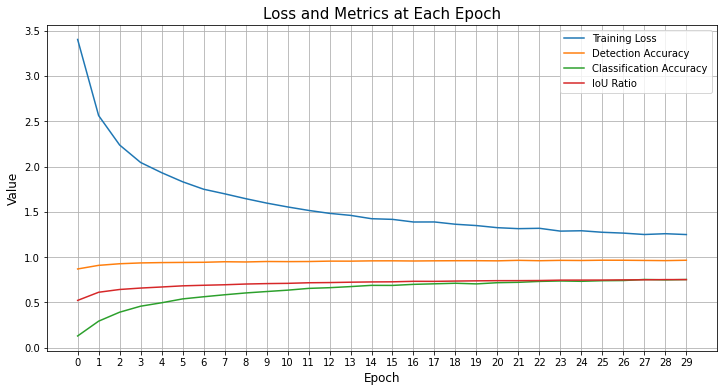

In [489]:
current_time = datetime.datetime.now()
FIGURE_FILE_PATH = os.path.join(FIGURE_PATH, "Fig_Training_Loss_v{}_{}.jpg".format(version_num, current_time.strftime("%Y%m%d_%H%M")))

plot_figure(plot_content=[loss, presence_acc, classification_acc, iou_ratio], 
            plot_label=["Training Loss", "Detection Accuracy", "Classification Accuracy", "IoU Ratio"], 
            figsize=(12,6), 
            title="Loss and Metrics at Each Epoch", 
            xlabel="Epoch", 
            ylabel="Value", 
            title_fontsize=15, 
            xlabel_fontsize=12, 
            ylabel_fontsize=12,
            savefig=False,
            filename=FIGURE_FILE_PATH,
            epoch=30)

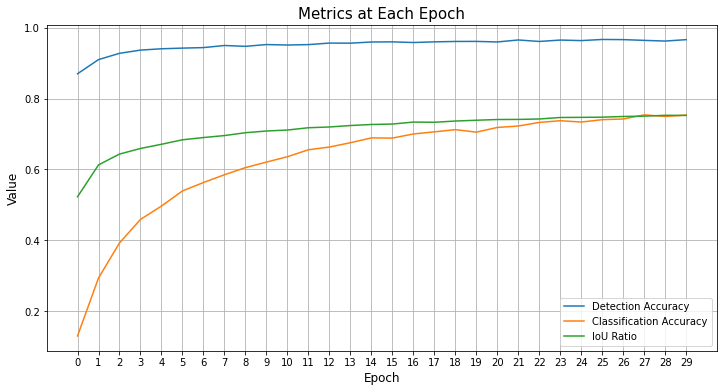

In [490]:
current_time = datetime.datetime.now()
FIGURE_FILE_PATH = os.path.join(FIGURE_PATH, "Fig_Training_Loss_v{}_{}.jpg".format(version_num, current_time.strftime("%Y%m%d_%H%M")))

plot_figure(plot_content=[presence_acc, classification_acc, iou_ratio], 
            plot_label=["Detection Accuracy", "Classification Accuracy", "IoU Ratio"], 
            figsize=(12,6), 
            title="Metrics at Each Epoch", 
            xlabel="Epoch", 
            ylabel="Value", 
            title_fontsize=15, 
            xlabel_fontsize=12, 
            ylabel_fontsize=12,
            savefig=False,
            filename=FIGURE_FILE_PATH,
            epoch=30)

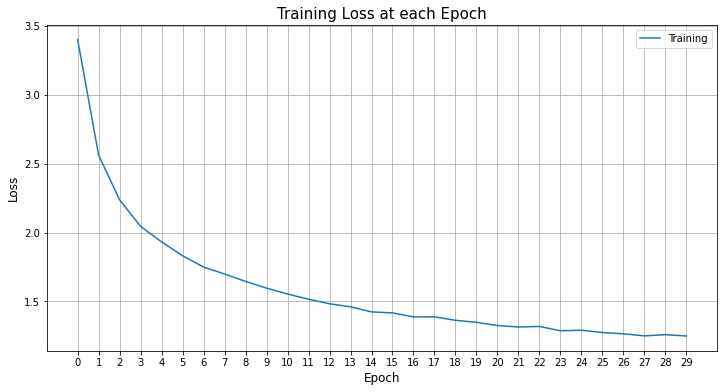

In [491]:
current_time = datetime.datetime.now()
FIGURE_FILE_PATH = os.path.join(FIGURE_PATH, "Fig_Training_Loss_v{}_{}.jpg".format(version_num, current_time.strftime("%Y%m%d_%H%M")))

plot_figure(plot_content=[loss], 
            plot_label=["Training"], 
            figsize=(12,6), 
            title="Training Loss at each Epoch", 
            xlabel="Epoch", 
            ylabel="Loss", 
            title_fontsize=15, 
            xlabel_fontsize=12, 
            ylabel_fontsize=12,
            savefig=True,
            filename=FIGURE_FILE_PATH,
            epoch=30)

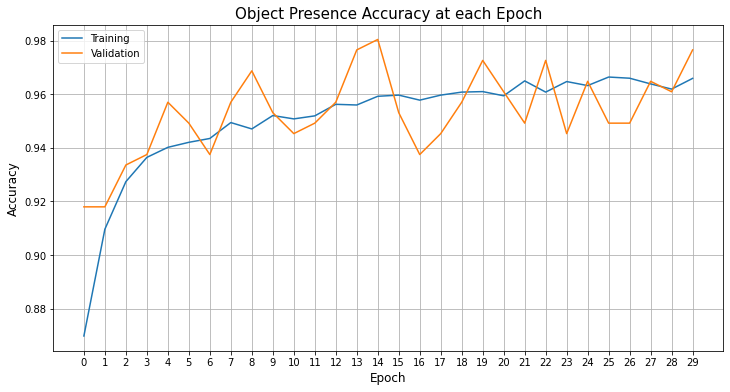

In [492]:
current_time = datetime.datetime.now()
FIGURE_FILE_PATH = os.path.join(FIGURE_PATH, "Fig_Presence_Acc_v{}_{}.jpg".format(version_num, current_time.strftime("%Y%m%d_%H%M")))

plot_figure(plot_content=[presence_acc, val_presence_acc], 
            plot_label=["Training", "Validation"], 
            figsize=(12,6), 
            title="Object Presence Accuracy at each Epoch", 
            xlabel="Epoch", 
            ylabel="Accuracy", 
            title_fontsize=15, 
            xlabel_fontsize=12, 
            ylabel_fontsize=12,
            savefig=True,
            filename=FIGURE_FILE_PATH,
            epoch=30)

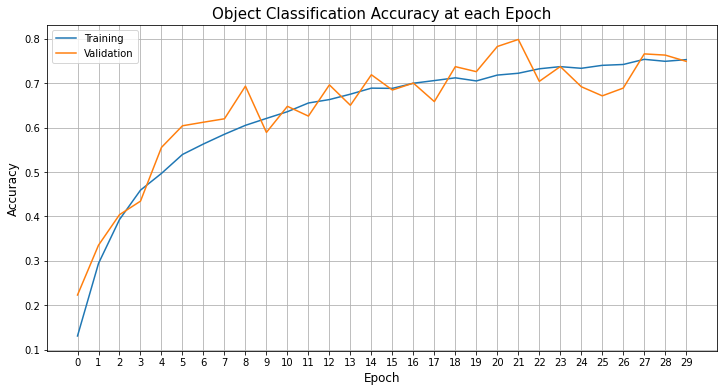

In [493]:
current_time = datetime.datetime.now()
FIGURE_FILE_PATH = os.path.join(FIGURE_PATH, "Fig_Classification_Acc_v{}_{}.jpg".format(version_num, current_time.strftime("%Y%m%d_%H%M")))

plot_figure(plot_content=[classification_acc, val_classification_acc], 
            plot_label=["Training", "Validation"], 
            figsize=(12,6), 
            title="Object Classification Accuracy at each Epoch", 
            xlabel="Epoch", 
            ylabel="Accuracy", 
            title_fontsize=15, 
            xlabel_fontsize=12, 
            ylabel_fontsize=12,
            savefig=True,
            filename=FIGURE_FILE_PATH, 
            epoch=30)

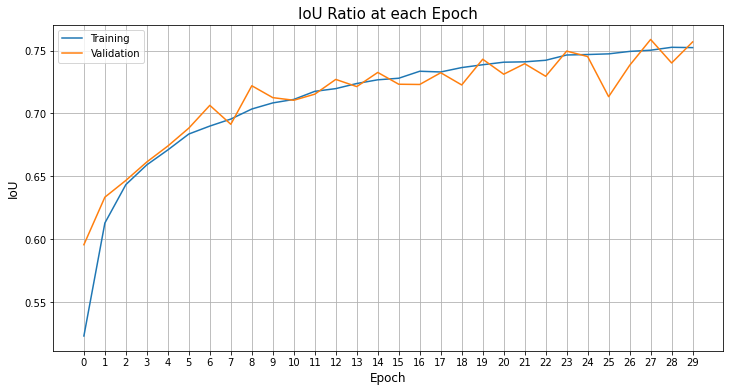

In [494]:
current_time = datetime.datetime.now()
FIGURE_FILE_PATH = os.path.join(FIGURE_PATH, "Fig_IoU_v{}_{}.jpg".format(version_num, current_time.strftime("%Y%m%d_%H%M")))

plot_figure(plot_content=[iou_ratio, val_iou_ratio], 
            plot_label=["Training", "Validation"], 
            figsize=(12,6), 
            title="IoU Ratio at each Epoch", 
            xlabel="Epoch", 
            ylabel="IoU", 
            title_fontsize=15, 
            xlabel_fontsize=12, 
            ylabel_fontsize=12,
            savefig=True,
            filename=FIGURE_FILE_PATH,
            epoch=30)

# 6) Make Predictions and Evaluate the Model

### 6.1) Make a few predicitons and visualise the results

In [104]:
# # Uncomment the command if want to load pretrained weights
# model.load_weights(filepath='Model/v24/Model_weights_030_1.249431.h5')

In [86]:
def image_generator_for_prediction(model, background_img_list, batch_size, image_row, image_col, appear_thresh, transform_bool=False, grayscale_bool=False, q_percentile=(0,100)):
    # Batch size of 1 is used for the prediction
    # Define a black image that will be replaced by a random hand fingerspelling image pasting on a random background
    X = np.zeros(shape=(batch_size, image_row, image_col, 3))
            
    if transform_bool == True:
        if  grayscale_bool == True:
            X_gray = np.zeros(shape=(batch_size, image_row, image_col, 1))
                    
    # Define the target array that will be replaced the correct value later
    # There is 8 (num of category) + 2 (1 coordinate) + 2 (bounding box resolution) + 1 (presence of object) = 13 outputs
    Y = np.zeros(shape=(batch_size, 31))
            
    # Starts the random image configuration from here
    for i in range(batch_size):
        # Pick a random background image path and load it
        bg_image_choice = np.random.choice(bg_image_list)
        bg_image = cv2.imread(bg_image_choice)
        bg_image = bg_image
        bg_image_row = bg_image.shape[0] # Background image height
        bg_image_col = bg_image.shape[1] # Background image width
        # Crop the background image into our desired dimension
        # Top left coordinate in the background image
        bg_image_row0 = np.random.randint(low=0, high=(bg_image_row - image_row))
        bg_image_col0 = np.random.randint(low=0, high=(bg_image_col - image_col))
        # Bottom right coordinate in the background image
        bg_image_row1 = bg_image_row0 + image_row
        bg_image_col1 = bg_image_col0 + image_col
        # Slice the zero array and replace it with the background image array (for a single batch)
        X[i,:,:,:] = bg_image[bg_image_row0:bg_image_row1, bg_image_col0:bg_image_col1, :]
                
                
        # Determine whether the hand appears or not
        appear = (np.random.random() < appear_thresh)
        if appear:
            # Pick a random fingerspelling alphabet and then pick a random image from that category
            # A number between 0 and 7 (26 types of alphabets)
            hand_type_index = np.random.choice(len(HAND_IMAGE_TYPE))
            # Choose a random alphabet based on the index above
            hand_type_choice = HAND_IMAGE_TYPE[hand_type_index]
            HAND_IMAGE_PATH = glob.glob("Image/CollectedImage/Hand_Image_Cropped_Further/{}/*.*g".format(hand_type_choice))
            # Choose a random image of the specific chosen alphabet
            hand_image_choice = np.random.choice(HAND_IMAGE_PATH)
            hand_image = cv2.imread(hand_image_choice)
                    
            # Resize the image depending on the resize factor
            resize_factor = np.random.uniform(low=0.45, high=0.65) # Resize factor between 0.35 and 0.65
            hand_image = cv2.resize(src=hand_image, dsize=(int(hand_image.shape[1]*resize_factor), int(hand_image.shape[0]*resize_factor)))
            hand_image_row = hand_image.shape[0] # Resized hand image height
            hand_image_col = hand_image.shape[1] # Resized hand image width
            # Top left coordinate in the output/cropped background image
            hand_image_row0 = np.random.randint(low=0, high=(image_row - hand_image_row))
            hand_image_col0 = np.random.randint(low=0, high=(image_col - hand_image_col))
            # Bottom right coordinate in the output/cropped background image
            hand_image_row1 = hand_image_row0 + hand_image_row
            hand_image_col1 = hand_image_col0 + hand_image_col
                    
            # Create a mask from the hand image and paste the hand image into the background
            # Crop a mask from the background image where the hands will be
            bg_mask = X[i,hand_image_row0:hand_image_row1, hand_image_col0:hand_image_col1, :]
            # A binary image where the hands pixel will be "False", whereas the black background will be "True"
            hand_mask = (hand_image == 0) # Shape of (hand_image_row, hand_image_col, 3)
            # An image where the hand pixel is black, whereas the background pixel remains
            # NOTE: black has pixel value 0, so any pixel value * black = black
            mask = bg_mask * hand_mask
            # An image where the hand pixels are pasted into the background image
            # NOTE: black has pixel value of 0, so any pixel value + black = that pixel value
            mask += hand_image
            # Paste the mask back into the background image
            X[i, hand_image_row0:hand_image_row1, hand_image_col0:hand_image_col1, :] = mask
            
            # Change the brightness of image
            modify_brightness = (np.random.random() < 0.8)
            if modify_brightness:
                X[i,:,:,:] = change_brightness(img=X[i,:,:,:], value=int(np.random.uniform(10, 70)))
            
                    
            if transform_bool == True:
                if grayscale_bool == True:
                    X_gray[i, :, :, :] = np.expand_dims(transformation(image=X[i, :, :, :], q_percentile=q_percentile, grayscale_bool=grayscale_bool), 2) / 255.0
                    # Make predictions for image with transformation and grayscale
                    #predictions_gray = model.predict(X_gray)
                else:
                    X[i, :, :, :] = transformation(image=X[i, :, :, :], q_percentile=q_percentile, grayscale_bool=grayscale_bool) / 255.0
                    # Make predictions for image with transformation but without grayscale
                    #predictions = model.predict(X)
            else:
                X[i, :, :, :] = X[i, :, :, :] / 255.0
                # Make predictions for image without transformation
                #predictions = model.predict(X)
                    
                
            # Define the target
            # 0: Presence of object, 1 denotes being present while 0 being absent
            Y[i, 0] = 1.0
            # 1 - 26: Classification target
            Y[i, 1 + hand_type_index] = 1.0
            # 9 - 12: Upper left coordinates, height, width of the hand image
            # NOTE: height and width of the image are used instead of the X, Y coordinate because sigmoid activation function only ensures
            # that the output is between 0 and 1, centered at 0.5 but doesn't ensure that the output is greater than the upper left corner coordinates
            Y[i, 26 + 1] = hand_image_row0 / image_row # Y coordinate of the hand upper left corner of the segmented hand image
            Y[i, 26 + 2] = hand_image_col0 / image_col # X coordinate of the hand upper left corner of the segmented hand image
            Y[i, 26 + 3] = hand_image_row / image_row # Height of the segmented hand image
            Y[i, 26 + 4] = hand_image_col / image_col # Width of the segmented hand image
                
        # When the object doesn't appear
        else:
            
            # Change the brightness of image
            modify_brightness = (np.random.random() < 0.8)
            if modify_brightness:
                X[i,:,:,:] = change_brightness(img=X[i,:,:,:], value=int(np.random.uniform(10, 70)))
            
            if transform_bool == True:
                if grayscale_bool == True:
                    X_gray[i,:,:,:] = np.expand_dims(transformation(image=X[i, :, :, :], q_percentile=q_percentile, grayscale_bool=grayscale_bool),2) / 255.0
                    # Make predictions for image with transformation and grayscale
                    #predictions_gray = model.predict(X_gray)
                else:
                    X[i,:,:,:] = transformation(image=X[i, :, :, :], q_percentile=q_percentile, grayscale_bool=grayscale_bool) / 255.0
                    # Make predictions for image with transformation but without grayscale
                    #predictions = model.predict(X)
            else:
                X[i, :, :, :] = X[i, :, :, :] / 255.0
                #predictions = model.predict(X)
    
    # Below section is the modification to original code, predict entire batch at once instead of predict each component of the batch individually
    if transform_bool == True:
        if grayscale_bool == True:
            predictions_gray = model.predict(X_gray)
    else:
        predictions = model.predict(X)
    
    return (X, Y, predictions) if grayscale_bool == False else (X_gray, Y, predictions_gray)

In [87]:
def parse_prediction(image, predictions, target):
    # Probability of object being present: 1.0 being present, 0.0 being absent
    prob_present = predictions[0]
    actual_prob_present = target[0]
    print("Object Presence: {}".format(prob_present))
    print("Actual Object Presence: {}\n".format(actual_prob_present))
    
    # Slice the probabilities correspond to the classification
    prob_class = predictions[1:27]
    # Get the index of the class with the highest probabilities
    prob_class_arg = prob_class.argmax()
    # Get the hand type corresponds to the class with highest probabilities
    hand_type = HAND_IMAGE_TYPE[prob_class_arg]
    print("Class: {}, prob: {}".format(hand_type, prob_class.max()))
    
    # Repeat the same process for target
    actual_prob_class = target[1:27]
    actual_prob_class_arg = actual_prob_class.argmax()
    actual_hand_type = HAND_IMAGE_TYPE[actual_prob_class_arg]
    print("Actual Class: {}\n".format(actual_hand_type))
        
    # Draw the predicted bounding box
    print("Bounding Box: {}".format(predictions[27:31]))
    # Conver the image dtype from np.float32 to np.uint8 (0-255)
    image_int = (image * 255).astype(np.uint8)
    # Convert the bbox coordinate from float, 0.0 - 1.0 to int, 0 - 255 as input into cv2.rectangle
    bbox_int = (predictions[27:31] * image.shape[1]).astype(np.int)
    pt1 = (bbox_int[1], bbox_int[0])
    pt2 = (bbox_int[1]+bbox_int[3], bbox_int[0]+bbox_int[2])
    rec = cv2.rectangle(img=image_int, pt1=pt1, pt2=pt2, color=(0,255,0), thickness=3)
    
    # Draw the actual bounding box
    print("Actual Bounding Box: {}".format(target[27:31]))
    # Convert the bbox coordinate from float to int as input into cv2.rectangle
    actual_bbox_int = (target[27:31] * image.shape[1]).astype(np.int)
    actual_pt1 = (actual_bbox_int[1], actual_bbox_int[0])
    actual_pt2 = (actual_bbox_int[1]+actual_bbox_int[3], actual_bbox_int[0]+actual_bbox_int[2])
    actual_rec = cv2.rectangle(img=rec, pt1=actual_pt1, pt2=actual_pt2, color=(255,0,0), thickness=3)
    plt.imshow(cv2.cvtColor(actual_rec, cv2.COLOR_BGR2RGB))

In [88]:
X, Y, pred = image_generator_for_prediction(model=model, background_img_list=validation_bg_list, batch_size=16, image_row=300, image_col=300, appear_thresh=0.8, transform_bool=False, grayscale_bool=False, q_percentile=(0,100))

In [89]:
choice_pred = 0
iou_list= calculate_iou(Y, pred)

Object Presence: 0.9995636343955994
Actual Object Presence: 1.0

Class: alphabet_l, prob: 0.5077505707740784
Actual Class: alphabet_l

Bounding Box: [0.34052718 0.19669321 0.48288652 0.5870267 ]
Actual Bounding Box: [0.31666667 0.17333333 0.57       0.63666667]
IoU: 0.7811168075334971


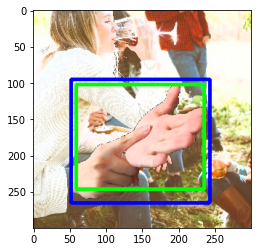

In [97]:
parse_prediction(image=X[choice_pred], predictions=pred[choice_pred], target=Y[choice_pred])
print("IoU: {}".format(iou_list[choice_pred]))

choice_pred += 1

In [80]:
np.mean(iou_list)

0.5892574031432498

Object Presence: 0.9983018636703491
Actual Object Presence: 1.0

Class: alphabet_o, prob: 0.6080160140991211
Actual Class: alphabet_o

Bounding Box: [0.25631842 0.24690571 0.41790456 0.63057196]
Actual Bounding Box: [0.25666667 0.27333333 0.4        0.56333333]
Object Presence: 0.933509111404419
Actual Object Presence: 1.0

Class: alphabet_z, prob: 0.8386695981025696
Actual Class: alphabet_z

Bounding Box: [0.15385105 0.58206517 0.4371378  0.43530506]
Actual Bounding Box: [0.15666667 0.56333333 0.42666667 0.41      ]
Object Presence: 0.43834388256073
Actual Object Presence: 0.0

Class: alphabet_g, prob: 0.7804502844810486
Actual Class: alphabet_a

Bounding Box: [0.40652406 0.27415937 0.35006845 0.4208262 ]
Actual Bounding Box: [0. 0. 0. 0.]
Object Presence: 0.9998364448547363
Actual Object Presence: 1.0

Class: alphabet_e, prob: 0.700128972530365
Actual Class: alphabet_e

Bounding Box: [0.38207576 0.16658263 0.40015158 0.5527755 ]
Actual Bounding Box: [0.38333333 0.18       0.39666667 

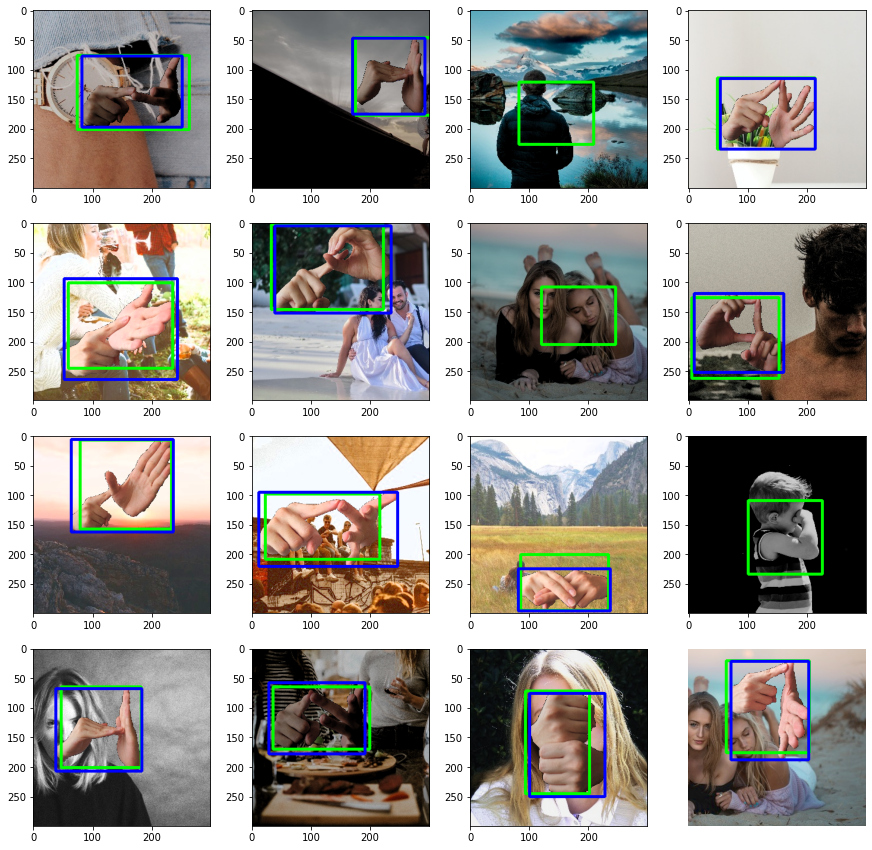

In [99]:
# To show multiple generated images at once
choice = 0
img_row = 4
img_col = 4

plt.figure(figsize=(15,15))
#plt.subplots(nrows=10, ncols=5)

for row in range(img_row):
    for col in range(img_col):
        plt.subplot(img_row, img_col, choice+1)
        parse_prediction(image=X[choice], predictions=pred[choice], target=Y[choice])
        choice += 1

plt.grid = False
plt.axis('off')
plt.savefig("Model/v24/Figure/Image_sample_prediction.jpg")
plt.show()

### 6.2) Generate a smaller dataset to evaluate the IoU ratio of the prediction

In [46]:
num_time = 100 # 16 samples for each run time, e.g. num_time = 100 means 100x16=1600 samples

# The prediction is separated due to hardware resources limitation
for i in range(num_time):
    if i == 0:
        X, Y, pred = image_generator_for_prediction(model=model, background_img_list=validation_bg_list, batch_size=16, image_row=300, image_col=300, appear_thresh=1.0, transform_bool=False, grayscale_bool=False, q_percentile=(0,100))
        Y_total = Y
        pred_total = pred
        print(i)
    else:
        X, Y, pred = image_generator_for_prediction(model=model, background_img_list=validation_bg_list, batch_size=16, image_row=300, image_col=300, appear_thresh=1.0, transform_bool=False, grayscale_bool=False, q_percentile=(0,100))
        Y_total = np.concatenate((Y_total, Y))
        pred_total = np.concatenate((pred_total, pred))
        print(i)

current_time = datetime.datetime.now()
np.save(os.path.join(ARRAY_PATH, "target_array_for_confusion_matrix_v{}_{}".format(version_num, current_time.strftime("%Y%m%d_%H%M"))), Y_total)
np.save(os.path.join(ARRAY_PATH, "prediction_array_for_confusion_matrix_v{}_{}".format(version_num, current_time.strftime("%Y%m%d_%H%M"))), pred_total)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [87]:
Y_total = np.load('Model/v24/Array/target_array_for_confusion_matrix_v24_20210802_1550.npy')
pred_total = np.load('Model/v24/Array/prediction_array_for_confusion_matrix_v24_20210802_1550.npy')

In [59]:
# Plot histogram to show the mean of the IoU of each target
# We can reuse the iou metrics functions that is used for the training process

alphabet_list = []
for alphabet in HAND_IMAGE_TYPE.values():
    alphabet_list.append(alphabet)

def plot_iou_histogram(y_true, y_pred):
    # Filter out the target and prediction array where there is only image with the object being present
    y_true_present = y_true[y_true[:,0]==1]
    y_pred_present = y_pred[y_true[:,0]==1]
    # Further filter out the target and prediction array where only the image with correctly predicted class is needed
    acc_prediction = tf.keras.metrics.categorical_accuracy(y_true=y_true_present[:,1:27], y_pred=y_pred_present[:,1:27])
    y_pred_acc = y_pred_present[ acc_prediction == 1.0]
    y_true_acc = y_true_present[ acc_prediction == 1.0]
    
    # Obtain the index of the predicted array with the highest probability
    class_index = y_pred_acc[:, 1:27].argmax(axis=1)
    
    iou_list = []
    
    # Define a list which contains the average IoU of each alphabet
    for i in range(26):
        y_true_inter = y_true_acc[class_index == i]
        y_pred_inter = y_pred_acc[class_index == i]
        # Return 0 for the average IoU ratio for a particular alphabet that don't even have at least 1 correct classification
        if y_true_inter.shape[0] == 0:
            iou_list.append(0)
        else:
            iou_mean = iou_metrics(y_true_inter, y_pred_inter)
            iou_value = iou_mean[0].numpy()
            iou_list.append(iou_value)
            
    # Visualise the defined list
    plt.figure(figsize=(23,7))
    plt.bar(x=range(len(iou_list)), height=iou_list )
    plt.xticks(ticks=range(len(iou_list)), labels=alphabet_list, rotation=40)
    plt.xlabel(xlabel="Alphabet", fontsize=15)
    plt.ylabel(ylabel="Average IoU Ratio", fontsize=15)
    plt.title("Average IoU Ratio of Each Alphabet", fontsize=20)
    plt.grid(axis='y')
    
    # Save the plotted bar plot
    current_time = datetime.datetime.now()
    plt.savefig(fname=os.path.join(FIGURE_PATH, "Bar_plot_of_IoU_Ratio_v{}_{}.jpg".format(version_num, current_time.strftime("%Y%m%d_%H%M") )))
    plt.show()
    
    return iou_list

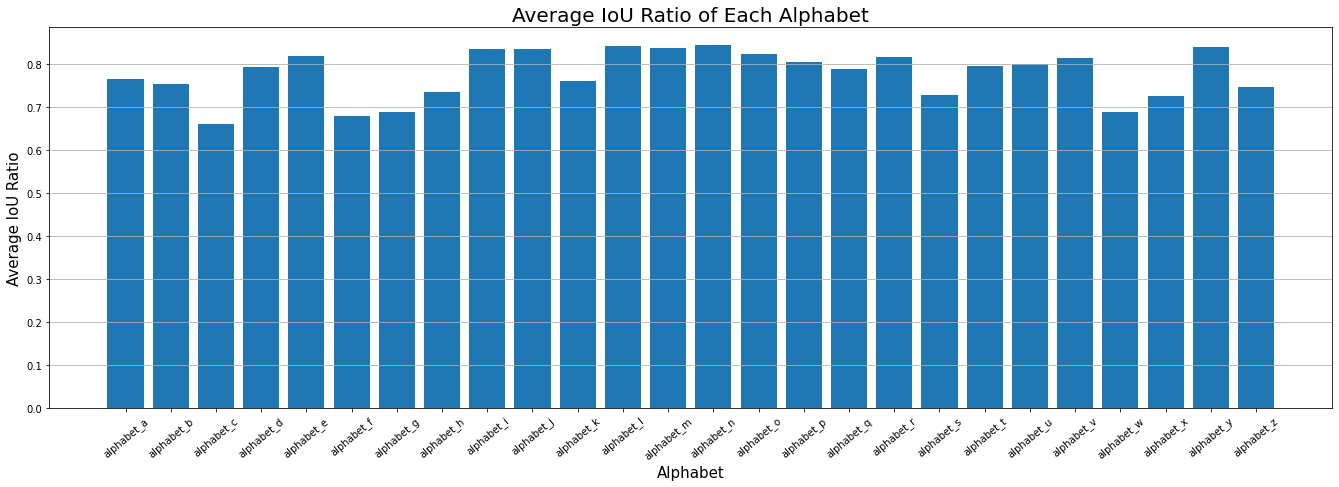

In [237]:
iou_list = plot_iou_histogram(y_true=Y_total, y_pred=pred_total)

### 6.3) Using the same smaller dataset to create a confusion matrix to evaluate the model's classification accuracy

In [ ]:
# Uncomment this part to load the saved confusion matrix array
# Y_total = np.load("Model/v16/target_array_for_confusion_matrix.npy")
# pred_total = np.load("Model/v16/prediction_array_for_confusion_matrix.npy")

In [103]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(target, predictions, label_map, cmap=plt.cm.Greens, normalize=False, savefig=True, filename="Confusion_Matrix.jpg"):
    cm = confusion_matrix(target, predictions)
    #print(cm)

    if normalize==True:
        cm = cm.astype('float') / cm.sum(axis=1)
        cm_title = "Confusion Matrix (with normalization)"
        form = ".2f"
    else:
        cm_title = "Confusion Matrix (without normalization)"
        form = "d"

    threshold = 0.5 * cm.max()

    plt.figure(figsize=(17,15))
    plt.imshow(cm, cmap=cmap)
    plt.title(cm_title, fontsize=15)
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.xticks(ticks=range(len(label_map)), labels=label_map, rotation=40)
    #plt.xticks(ticks=range(len(label_map)), label=label_map, rotation=40)
    # without the s in 'labels' the label name wont appear in the axis
    plt.yticks(ticks=range(len(label_map)), labels=label_map)

    for i, j in itertools.product(range(len(label_map)), range(len(label_map))):
      plt.text(x=i,
               y=j,
               s=format(cm[j][i],form),
               horizontalalignment='center',
               verticalalignment='center',
               fontsize=10,
               color='black' if cm[j][i] < threshold else "white")
    
    if savefig == True:
        plt.savefig(filename)
    
    plt.show()

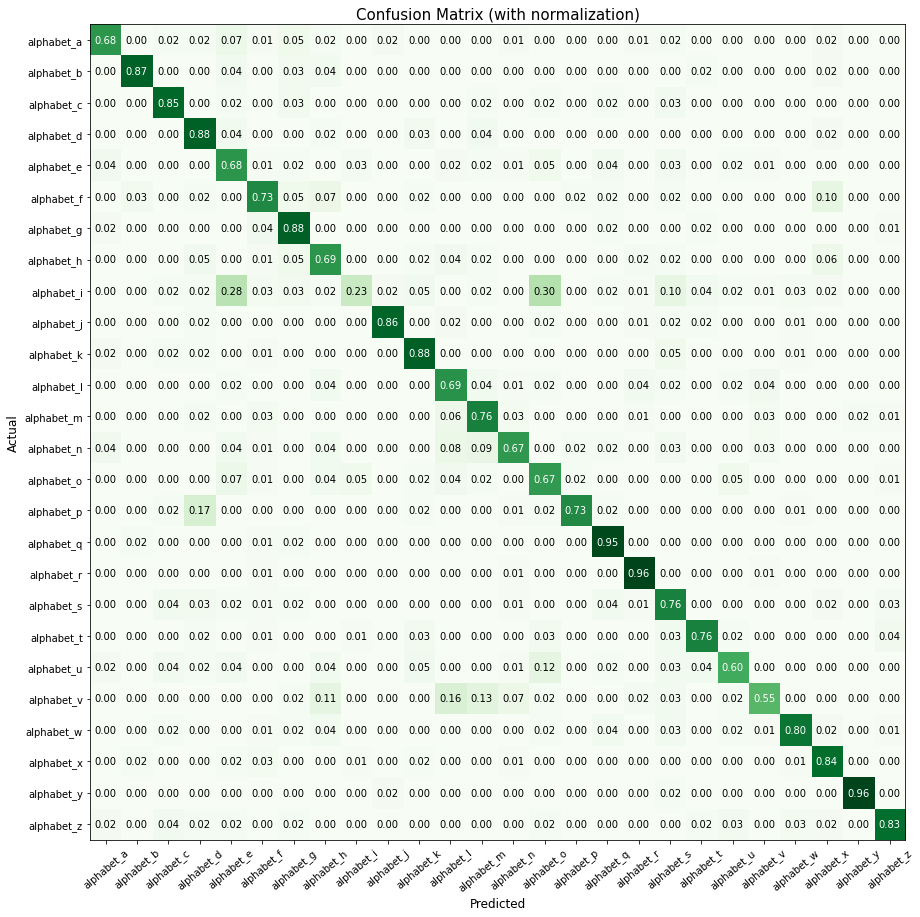

In [51]:
current_time = datetime.datetime.now()
FIGURE_FILE_PATH = os.path.join(FIGURE_PATH, "Confusion_Matrix_Norm_v{}_{}.jpg".format(version_num, current_time.strftime("%Y%m%d_%H%M")))

plot_confusion_matrix(target=Y_total[:, 1:27].argmax(axis=1), predictions=pred_total[:, 1:27].argmax(axis=1), label_map=list(HAND_IMAGE_TYPE.values()), normalize=True,
                      savefig=True,
                      filename=FIGURE_FILE_PATH)

### 6.4) Test the model on real-life data

In [104]:
def real_image_generator_for_prediction(dataset_type, model, batch_size, image_row, image_col, appear_thresh, transform_bool=False, grayscale_bool=False, q_percentile=(0,100)):
    # Batch size of 1 is used for the prediction
    # Define a black image that will be replaced by a random hand fingerspelling image pasting on a random background
    X = np.zeros(shape=(batch_size, image_row, image_col, 3))
            
    if transform_bool == True:
        if  grayscale_bool == True:
            X_gray = np.zeros(shape=(batch_size, image_row, image_col, 1))
                    
    # Define the target array that will be replaced the correct value later
    # There is 8 (num of category) + 2 (1 coordinate) + 2 (bounding box resolution) + 1 (presence of object) = 13 outputs
    Y = np.zeros(shape=(batch_size, 31))
            
    # Starts the random image configuration from here
    for i in range(batch_size):                
        # Determine whether the hand appears or not
        appear = (np.random.random() < appear_thresh)
        if appear:
            # Pick a random fingerspelling alphabet and then pick a random image from that category
            # A number between 0 and 7 (26 types of alphabets)
            hand_type_index = np.random.choice(len(HAND_IMAGE_TYPE))
            # Choose a random alphabet based on the index above
            hand_type_choice = HAND_IMAGE_TYPE[hand_type_index]
            HAND_IMAGE_PATH = glob.glob("Image/CollectedImage/Phone_0507_Resized_480/{}/{}/*.*g".format(dataset_type, hand_type_choice))
            # Choose a random image of the specific chosen alphabet
            hand_image_choice = np.random.choice(HAND_IMAGE_PATH)
            hand_image = cv2.imread(hand_image_choice)
                    
            # Resize the image into appropriate shape as input into the model
            hand_image = cv2.resize(src=hand_image, dsize=(image_col, image_row))
                    
            X[i,:,:,:] = hand_image
            
            # Change the brightness of image
            modify_brightness = (np.random.random() < 0.8)
            if modify_brightness:
                X[i,:,:,:] = change_brightness(img=X[i,:,:,:], value=int(np.random.uniform(10, 70)))
            
            if transform_bool == True:
                if grayscale_bool == True:
                    X_gray[i, :, :, :] = np.expand_dims(transformation(image=X[i, :, :, :], q_percentile=q_percentile, grayscale_bool=grayscale_bool), 2) / 255.0
                    # Make predictions for image with transformation and grayscale
                    #predictions_gray = model.predict(X_gray)
                else:
                    X[i, :, :, :] = transformation(image=X[i, :, :, :], q_percentile=q_percentile, grayscale_bool=grayscale_bool) / 255.0
                    # Make predictions for image with transformation but without grayscale
                    #predictions = model.predict(X)
            else:
                X[i, :, :, :] = X[i, :, :, :] / 255.0
                # Make predictions for image without transformation
                #predictions = model.predict(X)
                    
                
            # Define the target
            # 0: Presence of object, 1 denotes being present while 0 being absent
            Y[i, 0] = 1.0
            # 1 - 26: Classification target
            Y[i, 1 + hand_type_index] = 1.0
            # 9 - 12: Upper left coordinates, height, width of the hand image
            # NOTE: height and width of the image are used instead of the X, Y coordinate because sigmoid activation function only ensures
            # that the output is between 0 and 1, centered at 0.5 but doesn't ensure that the output is greater than the upper left corner coordinates
            # Replace the 'jpg' file extension with 'xml' to access the annotation file
            ANNOTATION_PATH = hand_image_choice[:-3] + "xml"
            # Parse an XML document into an element tree
            anno_tree = ET.parse(source=ANNOTATION_PATH)
            # Identify the root of the element tree
            anno_root = anno_tree.getroot()
            bndbox_tag = anno_root.find('object').find('bndbox')
            size_tag = anno_root.find('size')
            # Using the annotation info from the xml document to define the annotation coordinate ratio
            Y[i, 26 + 1] = int(bndbox_tag.find('ymin').text) / int(size_tag.find('height').text) # Y coordinate of the hand upper left corner of the segmented hand image
            Y[i, 26 + 2] = int(bndbox_tag.find('xmin').text) / int(size_tag.find('width').text) # X coordinate of the hand upper left corner of the segmented hand image
            Y[i, 26 + 3] = (int(bndbox_tag.find('ymax').text) - int(bndbox_tag.find('ymin').text)) / int(size_tag.find('height').text) # Height of the segmented hand image
            Y[i, 26 + 4] = (int(bndbox_tag.find('xmax').text) - int(bndbox_tag.find('xmin').text)) / int(size_tag.find('width').text) # Width of the segmented hand image
                
        # When the object doesn't appear
        else:
            # Display the images without any hand showing the alphabet present
            BACKGROUND_IMAGE_PATH = glob.glob("Image/CollectedImage/Phone_0507_Resized_480/{}/Background/*.*g".format(dataset_type))
            background_image_choice = np.random.choice(BACKGROUND_IMAGE_PATH)
            background_image = cv2.imread(background_image_choice)
                
            # Resize the image into appropriate image size
            background_image = cv2.resize(src=background_image, dsize=(image_col, image_row))
                
            X[i,:,:,:] = background_image
            
            # Change the brightness of image
            modify_brightness = (np.random.random() < 0.8)
            if modify_brightness:
                X[i,:,:,:] = change_brightness(img=X[i,:,:,:], value=int(np.random.uniform(10, 70)))
            
            if transform_bool == True:
                if grayscale_bool == True:
                    X_gray[i,:,:,:] = np.expand_dims(transformation(image=X[i, :, :, :], q_percentile=q_percentile, grayscale_bool=grayscale_bool),2) / 255.0
                    # Make predictions for image with transformation and grayscale
                    #predictions_gray = model.predict(X_gray)
                else:
                    X[i,:,:,:] = transformation(image=X[i, :, :, :], q_percentile=q_percentile, grayscale_bool=grayscale_bool) / 255.0
                    # Make predictions for image with transformation but without grayscale
                    #predictions = model.predict(X)
            else:
                X[i, :, :, :] = X[i, :, :, :] / 255.0
                #predictions = model.predict(X)
    
    # Below section is the modification to original code, predict entire batch at once instead of predict each component of the batch individually
    if transform_bool == True:
        if grayscale_bool == True:
            predictions_gray = model.predict(X_gray)
    else:
        predictions = model.predict(X)
    
    return (X, Y, predictions) if grayscale_bool == False else (X_gray, Y, predictions_gray)

In [106]:
import xml.etree.ElementTree as ET

In [107]:
X_real, Y_real, pred_real = real_image_generator_for_prediction(dataset_type="Train", model=model, batch_size=16, image_row=300, image_col=300, appear_thresh=0.8, transform_bool=False, grayscale_bool=False, q_percentile=(0,100))

In [108]:
choice_pred_real = 0
iou_list_real= calculate_iou(Y_real, pred_real)

Object Presence: 0.9916961789131165
Actual Object Presence: 1.0

Class: alphabet_z, prob: 0.49271777272224426
Actual Class: alphabet_o

Bounding Box: [0.42672083 0.163524   0.40314737 0.5081078 ]
Actual Bounding Box: [0.36875   0.165625  0.44375   0.5046875]
IoU: 0.8316888878593959


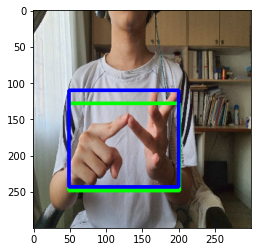

In [119]:
parse_prediction(image=X_real[choice_pred_real], predictions=pred_real[choice_pred_real], target=Y_real[choice_pred_real])
print("IoU: {}".format(iou_list_real[choice_pred_real]))

choice_pred_real += 1

In [120]:
num_time = 40 # 100 samples for each run time, e.g. num_time = 5 means 500 samples

# The prediction is separated due to hardware resources limitation
for i in range(num_time):
    if i == 0:
        X, Y, pred = real_image_generator_for_prediction(dataset_type="Train", model=model, batch_size=16, image_row=300, image_col=300, appear_thresh=1.0, transform_bool=False, grayscale_bool=False, q_percentile=(0,100))
        real_Y_total = Y
        real_pred_total = pred
        print(i)
    else:
        X, Y, pred = real_image_generator_for_prediction(dataset_type="Train", model=model, batch_size=16, image_row=300, image_col=300, appear_thresh=1.0, transform_bool=False, grayscale_bool=False, q_percentile=(0,100))
        real_Y_total = np.concatenate((real_Y_total, Y))
        real_pred_total = np.concatenate((real_pred_total, pred))
        print(i)

current_time = datetime.datetime.now()
np.save(os.path.join(ARRAY_PATH, "real_target_array_for_confusion_matrix_v{}_{}".format(version_num, current_time.strftime("%Y%m%d_%H%M"))), real_Y_total)
np.save(os.path.join(ARRAY_PATH, "real_prediction_array_for_confusion_matrix_v{}_{}".format(version_num, current_time.strftime("%Y%m%d_%H%M"))), real_pred_total)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [58]:
real_Y_total = np.load('Model/v24/Array/real_target_array_for_confusion_matrix_v24_20210803_2100.npy')
real_pred_total = np.load('Model/v24/Array/real_prediction_array_for_confusion_matrix_v24_20210803_2100.npy')

#### 6.4.1) Evaluate the model detection accuracy on fingerspelling hand

In [92]:
presence_acc = tf.keras.metrics.binary_accuracy(y_true=real_Y_total[:,0],y_pred=real_pred_total[:,0])
presence_acc

<tf.Tensor: shape=(), dtype=float32, numpy=0.9953125>

#### 6.4.2) Evaluate the IoU ratio on the real-life data

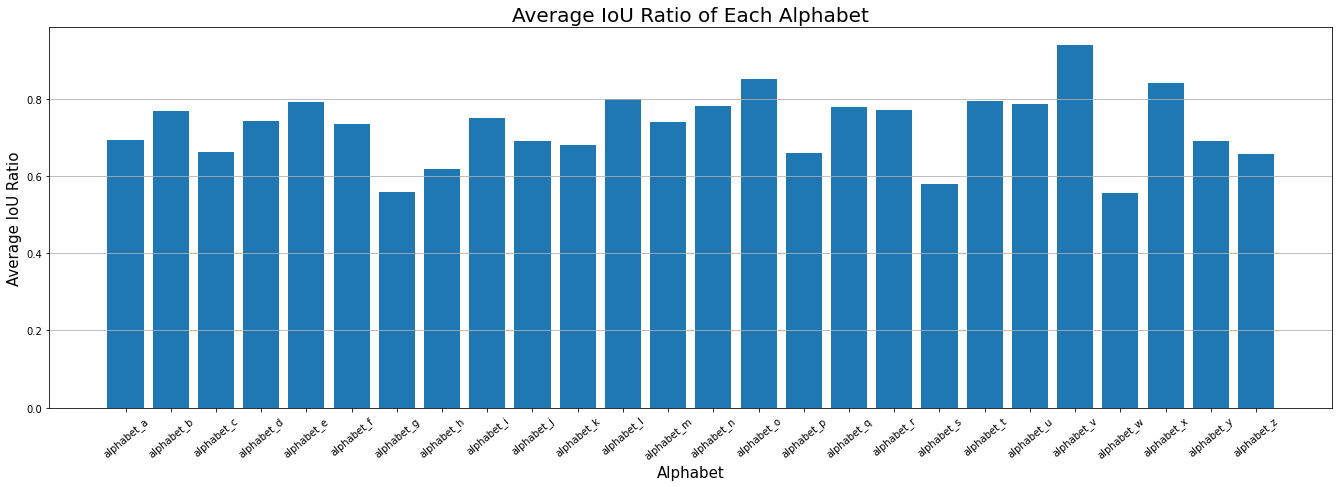

In [60]:
iou_list = plot_iou_histogram(y_true=real_Y_total, y_pred=real_pred_total)

#### 6.4.3) Create a confusion matrix to evaluate the model classification accuracy on real-life data

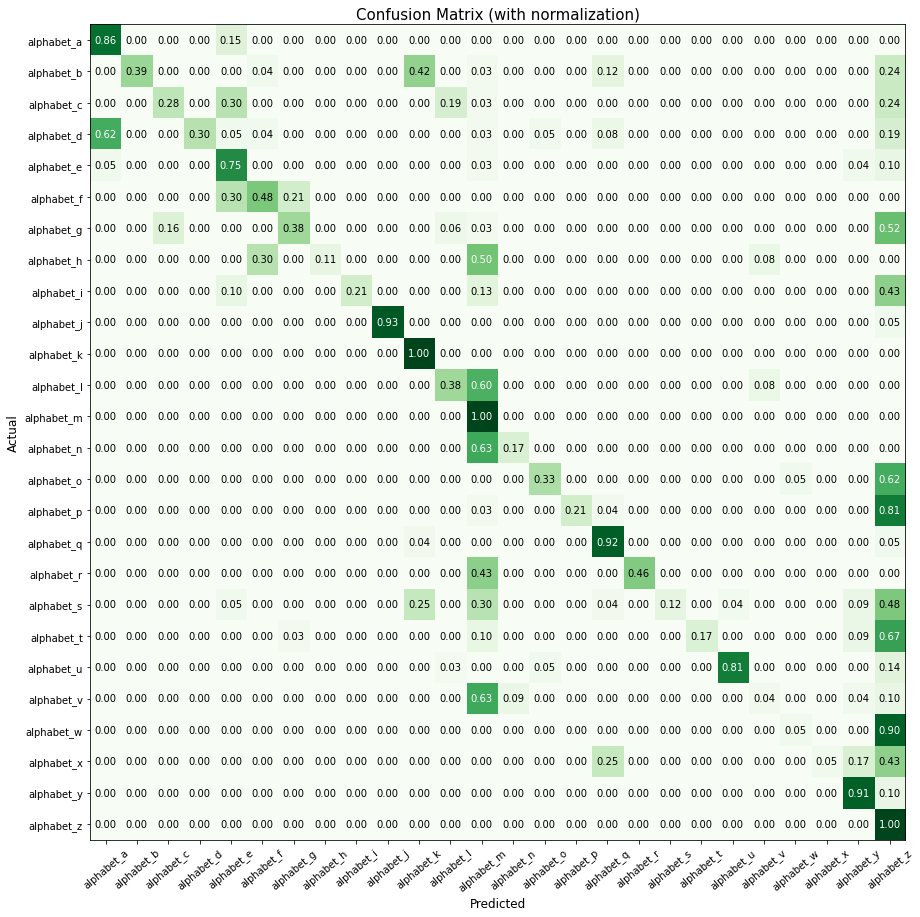

In [91]:
current_time = datetime.datetime.now()
FIGURE_FILE_PATH = os.path.join(FIGURE_PATH, "Real_Confusion_Matrix_Norm_v{}_{}.jpg".format(version_num, current_time.strftime("%Y%m%d_%H%M")))

plot_confusion_matrix(target=real_Y_total[:, 1:27].argmax(axis=1), predictions=real_pred_total[:, 1:27].argmax(axis=1), label_map=list(HAND_IMAGE_TYPE.values()), normalize=True,
                      savefig=True,
                      filename=FIGURE_FILE_PATH)

# 7) Make Real Time Prediction

In [146]:
class CountsPerSec:
    def __init__(self):
        self.start_time = None
        self.count = 0
        
    def start(self):
        self.start_time = datetime.datetime.now()
        return self
    
    def counting(self):
        self.count += 1
    
    def countpersec(self):
        elapsed_time = self.elapsed_time()
        # Offset the time to at least 0.1 in order to avoid zerodivision error
        if elapsed_time == 0:
            elapsed_time = 0.0001
        return self.count / elapsed_time
    
    def elapsed_time(self):
        return (datetime.datetime.now() - self.start_time).total_seconds()


class VideoGetter:
    def __init__(self, src=0):
        self.cap = cv2.VideoCapture(src) # Default src as 0, which is the default webcam
        self.ret, self.frame = self.cap.read()
        self.stopped = True
        
    def start_thread(self):
        # Set the condition to start grabbing video frames
        self.stopped = False
        # NameError: name 'video_get' is not defined
        # MUST use target=self.video_get
        x = threading.Thread(target=self.video_get, args=())
        x.start()
        return self
        
    def video_get(self):
        while self.stopped != True:
            if self.ret == True:
                self.ret , self.frame = self.cap.read()
            else:
                self.stopped = True
                
    def stop(self):
        # Set the condition to stop grabbing video frames
        self.stopped = True
        self.cap.release()
        

In [147]:
import threading

In [148]:
def insertCPS(frame, counts_per_sec):
    cv2.putText(frame, "CPS: {}".format(counts_per_sec), (10, 280), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0,255,0), 1)
    return frame

In [150]:
# Test with the model
cps = CountsPerSec()
vg = VideoGetter()

# A class that keeps track of how many times the main process are run in the main thread within a second
# NOTE: This does not reflect to the actual fps which could be limited by the display hardware etc.
cps.start()
# Initiate an another thread for reading the frames
vg.start_thread()

while True:
    frame = vg.frame
    
    # Preprocess the image to be fed into the model
    # Blur the frame since there is alot of noise
    frame_process = cv2.medianBlur(frame, 3)
    # Resize the image into the input shape required for the model
    frame_process = cv2.resize(frame_process, (300,300))
    # Expand the dimension as required to be fed into the model
    frame_pred = np.expand_dims(frame_process, 0) # Shape of (1, 300, 300, 3)
    # Convert the pixel value from 0-255 to 0-1 to be fed into the model
    frame_pred = frame_pred / 255.0
    
    # Feed the input image into the model
    pred_frame = model.predict(x=frame_pred)
    
    # Parse the prediction
    # Probability of object being present
    prob_present = pred_frame[0][0]
    
    if prob_present > 0.50:
        # Probability of identifying the object (Type of fingerspelling alphabet)
        prob_class = pred_frame[0][1:27]
        prob_class_arg = prob_class.argmax() # Return the index with the highest prob
        hand_type = HAND_IMAGE_TYPE[prob_class_arg] # Using the index to identify the corresponding alphabet through the predefined dictionary
    
        # Probability of object localisation
        prob_local = pred_frame[0][27:31]
        prob_class_max = prob_class.max()
        bbox_int = (prob_local * 300).astype(np.int)
        pt1 = (bbox_int[1], bbox_int[0])
        pt2 = (bbox_int[1]+bbox_int[3], bbox_int[0]+bbox_int[2])
        cv2.rectangle(img=frame_process, pt1=pt1, pt2=pt2, color=(0,255,0), thickness=1)
        
        # Convert back to original resolution before displaying texts on the image
        frame_display = cv2.resize(frame_process, (640,480))
        cv2.rectangle(img=frame_display, pt1=(5, 42), pt2=((80*prob_class_max).astype(np.int), 55), color=(0,255,0), thickness=-1)
        cv2.putText(frame_display, "Class: {}".format(hand_type), (5,37), cv2.FONT_HERSHEY_COMPLEX, 0.7, (0,255,0), 1)
        
    else:
        frame_display = frame.copy()
        cv2.putText(frame_display, "Class: None", (5,37), cv2.FONT_HERSHEY_COMPLEX, 0.7, (0,255,0), 1)
        
    # A text indicating whether the object present in the frame or not
    cv2.putText(frame_display, "Object Presence: {}".format(prob_present), (5,17), cv2.FONT_HERSHEY_COMPLEX, 0.7, (0,255,0), 1)
    # Draws an empty rectangle which will be integrated with a changing rectangle indicating the class probability
    cv2.rectangle(frame_display, (5, 42), (80, 55), (0,255,0), thickness=1)
    
    cps.counting()
    cv2.putText(frame_display, "CPS: {}".format(cps.countpersec()), (5, 475), cv2.FONT_HERSHEY_COMPLEX, 0.7, (0,255,0), 1)
    
    # Display the images
    cv2.imshow('Frame', frame_display.astype(np.uint8))
    
    if cv2.waitKey(1) == ord('q'):
        vg.stop()
        break

cv2.destroyAllWindows()

In [138]:
frame = cv2.imread("Image/CollectedImage/Prediction_Testing/WIN_20210802_15_44_31_Pro.jpg")
    
# Preprocess the image to be fed into the model
# Resize the image into the input shape required for the model
frame_process = cv2.resize(frame, (300,300))
frame_pred = np.expand_dims(frame_process, 0) # Shape of (1, 300, 300, 3)
frame_pred = frame_pred / 255.0
    
# Feed the input image into the model
pred_frame = model.predict(x=frame_pred)
    
# Parse the prediction
# Probability of object being present
prob_present = pred_frame[0][0]
    
if prob_present > 0.70:
    # Probability of identifying the object (Type of fingerspelling alphabet)
    prob_class = pred_frame[0][1:27]
    prob_class_arg = prob_class.argmax() # Return the index with the highest prob
    hand_type = HAND_IMAGE_TYPE[prob_class_arg] # Using the index to identify the corresponding alphabet through the predefined dictionary
    
    # Probability of object localisation
    prob_local = pred_frame[0][27:31]
    bbox_int = (prob_local * 300).astype(np.int)
    pt1 = (bbox_int[1], bbox_int[0])
    pt2 = (bbox_int[1]+bbox_int[3], bbox_int[0]+bbox_int[2])
    rec = cv2.rectangle(img=frame_process, pt1=pt1, pt2=pt2, color=(0,255,0), thickness=3)

In [139]:
hand_type

'alphabet_q'

In [140]:
prob_class_arg

16

In [141]:
prob_class.max()

0.34653276

In [142]:
prob_present

0.98570204

In [143]:
prob_class

array([0.00216531, 0.00878366, 0.01782889, 0.01016263, 0.0027388 ,
       0.14249419, 0.00871196, 0.01270593, 0.00200257, 0.00226274,
       0.3314068 , 0.01103334, 0.00580515, 0.00436726, 0.00210975,
       0.00474604, 0.34653276, 0.0037459 , 0.01095155, 0.02505412,
       0.00252308, 0.00165466, 0.00074239, 0.00521596, 0.00117896,
       0.03307563], dtype=float32)

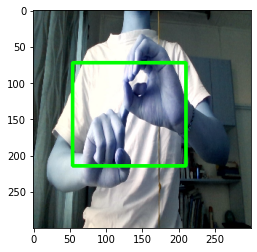

In [144]:
plt.imshow(frame_process)